In [2]:
import pandas as pd
import xarray as xr
import math
import numpy as np

import shap

import seaborn as sns
 
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe

from pandas import DataFrame
from pandas import concat

from joypy import joyplot
import joypy

import joblib
import re

from CombinedForML import *

# Data Processing

In [ ]:
trajs.columns

In [3]:
# Calculating Mass

radius_eq = trajs['radius_eq(ice)[m]'].values
density_droplet = trajs['density(droplet/ice)[kg/m3]'].values

volume_particle = ((4/3) * math.pi * (radius_eq **3))
mass = density_droplet * volume_particle

trajs['Mass of Particle (kg/m^2)'] = mass
trajs

Unnamed: 0   rk_deact         x[m]        y[m]       z[m]  vz[m]  \
0                0  416298675  10018.82600   4721.1706  9700.0887    0.0   
1                1  416321552  10024.80000   4862.7437  9217.3873    0.0   
2                2  416381888  10105.69200   4666.4138  9488.2015    0.0   
3                3  416504775  10181.85100   4875.8173  9771.5103    0.0   
4                4  416548289  10443.32200   4795.5244  9447.3769    0.0   
...            ...        ...          ...         ...        ...    ...   
356971      356971  889436797    595.06533  10783.6590  9233.5314    0.0   
356972      356972  891193957    660.81691  10988.7690  9712.9225    0.0   
356973      356973  889164689    616.78859  10808.0370  9519.0326    0.0   
356974      356974  889818873    513.62752  10953.5070  8256.2673    0.0   
356975      356975  891981613    870.00045  10514.4240  9778.6062    0.0   

        radius(droplet)[m]  mass_of_aerosol_in_droplet/ice(1:01)[g]  \
0                      0.0                             1.445146e-14   
1                      0.0                             6.131097e-13   
2                      0.0                             1.246443e-13   
3                      0.0                             3.413662e-14   
4                      0.0                             4.397361e-13   
...                    ...                                      ...   
356971                 0.0                             1.304915e-13   
356972                 0.0                             1.859583e-14   
356973                 0.0                             3.186807e-14   
356974                 0.0                             4.656712e-13   
356975                 0.0                             6.789966e-14   

        radius_eq(ice)[m]  radius_pol(ice)[m]  ...     out11       out12  \
0                0.000041            0.000041  ...  0.046420  281.198883   
1                0.000055            0.000055  ...  0.103655  284.903656   
2                0.000044            0.000044  ...  0.088963  327.211578   
3                0.000026            0.000026  ...  0.049123  455.577545   
4                0.000029            0.000029  ...  0.052219  359.855774   
...                   ...                 ...  ...       ...         ...   
356971           0.000035            0.000035  ...  0.025803  683.162720   
356972           0.000032            0.000032  ...  0.043627  351.011658   
356973           0.000033            0.000033  ...  0.054211  282.849457   
356974           0.000130            0.000130  ...  0.437322  220.400070   
356975           0.000035            0.000035  ...  0.064395  309.146698   

            out13      out14      deactrat       T [K]    RH_ice  RH_liquid  \
0        9.730305   9.730305  6.000385e-09  228.388044  1.014500   0.650835   
1        8.427178   8.427178  1.602579e-10  232.900874  1.002869   0.673966   
2        7.556598   7.556598  5.511436e-09  231.154231  1.016322   0.670886   
3        7.078797   7.078797  6.816537e-10  228.411551  1.006467   0.645838   
4        8.673096   8.673096  2.194830e-08  231.272692  1.017096   0.672215   
...           ...        ...           ...         ...       ...        ...   
356971  17.033659  17.033659  6.506783e-09  232.738183  1.012825   0.679526   
356972  10.050905  10.050905  3.275800e-08  228.138477  1.027677   0.657588   
356973   9.916177   9.916177  3.735348e-08  230.051883  1.028568   0.671304   
356974   4.644490   4.644490 -7.213148e-08  240.850594  0.949227   0.691041   
356975  11.298161  11.298161  5.903493e-08  228.171312  1.034476   0.662164   

         RH_diff  Mass of Particle (kg/m^2)  
0       0.008779               1.067392e-10  
1       0.008370               1.907118e-10  
2       0.008611               7.005871e-11  
3       0.008711               3.538106e-11  
4       0.008623               2.674286e-11  
...          ...                        ...  
356971  0.008449               5.884953e-11  
356972  0.00

In [4]:
#Creating a copy of a dataframe and merging together
df_trajs = trajs

sort_cols = ['time', 'rk_deact']
df_sort = df_trajs.sort_values(by=sort_cols)

df2_trajs = trajs[trajs['time'] != 5100]
df_trajs = trajs[trajs['time'] != 7200]

df2_trajs = df2_trajs.add_suffix('_1')

df_trajs = df_trajs.sort_values(by=['time', 'rk_deact']).reset_index(drop=True)
df2_trajs = df2_trajs.sort_values(by=['time_1', 'rk_deact_1']).reset_index(drop=True)

df = pd.concat([df_trajs, df2_trajs], axis=1)
df

Unnamed: 0    rk_deact         x[m]         y[m]       z[m]  vz[m]  \
0             4360       13957    187.02308    131.37815  9362.9834    0.0   
1             4361      150328    280.41348    123.98104  9479.3545    0.0   
2             4362      206362    362.41535    226.61712  9679.0052    0.0   
3             4363      207674    433.96419    252.61293  9350.2859    0.0   
4             4364      218111    123.32099    369.23415  9486.0378    0.0   
...            ...         ...          ...          ...        ...    ...   
347055      343778  1015230609  11655.36400  11895.40400  9597.7637    0.0   
347056      343779  1015266378  11743.64800  11799.43100  9758.7617    0.0   
347057      343780  1015305678  11771.92800  11686.20800  8977.0945    0.0   
347058      340080  1015329135  11473.41500  11976.99200  9335.0350    0.0   
347059      342430  1015454933  11861.36900    180.93205  9446.7867    0.0   

        radius(droplet)[m]  mass_of_aerosol_in_droplet/ice(1:01)[g]  \
0                      0.0                             1.048439e-14   
1                      0.0                             1.776257e-14   
2                      0.0                             2.233854e-14   
3                      0.0                             2.910743e-13   
4                      0.0                             8.156556e-14   
...                    ...                                      ...   
347055                 0.0                             1.902701e-14   
347056                 0.0                             5.646258e-15   
347057                 0.0                             1.904751e-13   
347058                 0.0                             8.063607e-14   
347059                 0.0                             6.797282e-13   

        radius_eq(ice)[m]  radius_pol(ice)[m]  ...   out11_1     out12_1  \
0                0.000013            0.000013  ...  0.055903  336.595032   
1                0.000021            0.000021  ...  0.038377  354.739624   
2                0.000026            0.000026  ...  0.025751  302.004425   
3                0.000033            0.000033  ...  0.069063  420.421875   
4                0.000018            0.000018  ...  0.024851  320.557495   
...                   ...                 ...  ...       ...         ...   
347055           0.000022            0.000022  ...  0.025684  414.409027   
347056           0.000013            0.000013  ...  0.008966  385.077393   
347057           0.000087            0.000087  ...  0.191952  367.272278   
347058           0.000056            0.000056  ...  0.042907  524.944641   
347059           0.000061            0.000061  ...  0.059544  348.354309   

          out13_1    out14_1    deactrat_1     T [K]_1  RH_ice_1  RH_liquid_1  \
0       14.001214  14.001214 -6.621117e-09  232.110924  0.997001     0.664628   
1        9.352058   9.352058 -2.457631e-09  231.159666  1.000650     0.660578   
2        6.072549   6.072549  1.721107e-09  229.309070  1.003703     0.650070   
3        7.234190   7.234190  8.823843e-09  232.071147  1.017993     0.678345   
4        6.739596   6.739596 -2.079506e-09  231.189258  1.001454     0.661310   
...           ...        ...           ...         ...       ...          ...   
347055  13.616765  13.616765 -6.029041e-08  229.940011  0.983420     0.641098   
347056   5.706291   5.706291 -3.655712e-08  228.075858  0.989389     0.632679   
347057   0.015625   0.015625  1.539362e-09  235.261644  1.017356     0.700312   
347058  19.641491  19.641491  7.995893e-09  231.851583  1.010303     0.671707   
347059  15.680635  15.680635  3.769227e-08  230.985889  1.024081     0.674839   

        RH_diff_1  Mass of Particle (kg/m^2)_1  
0        0.008388                 3.603907e-12  
1        0.008478                 1.376532e-11  
2        0.008626                 1.544887e-11  
3        0.008563                 4.600479e-11  
4        0.008486                 7.891735e-12  
...           ...                     

In [42]:
df[['time', 'time_1']]

time  time_1
0       5100    5160
1       5100    5160
2       5100    5160
3       5100    5160
4       5100    5160
...      ...     ...
347055  7140    7200
347056  7140    7200
347057  7140    7200
347058  7140    7200
347059  7140    7200

[347060 rows x 2 columns]

In [5]:
df['Change in Mass'] = df['Mass of Particle (kg/m^2)_1'] - df['Mass of Particle (kg/m^2)']
df

Unnamed: 0    rk_deact         x[m]         y[m]       z[m]  vz[m]  \
0             4360       13957    187.02308    131.37815  9362.9834    0.0   
1             4361      150328    280.41348    123.98104  9479.3545    0.0   
2             4362      206362    362.41535    226.61712  9679.0052    0.0   
3             4363      207674    433.96419    252.61293  9350.2859    0.0   
4             4364      218111    123.32099    369.23415  9486.0378    0.0   
...            ...         ...          ...          ...        ...    ...   
347055      343778  1015230609  11655.36400  11895.40400  9597.7637    0.0   
347056      343779  1015266378  11743.64800  11799.43100  9758.7617    0.0   
347057      343780  1015305678  11771.92800  11686.20800  8977.0945    0.0   
347058      340080  1015329135  11473.41500  11976.99200  9335.0350    0.0   
347059      342430  1015454933  11861.36900    180.93205  9446.7867    0.0   

        radius(droplet)[m]  mass_of_aerosol_in_droplet/ice(1:01)[g]  \
0                      0.0                             1.048439e-14   
1                      0.0                             1.776257e-14   
2                      0.0                             2.233854e-14   
3                      0.0                             2.910743e-13   
4                      0.0                             8.156556e-14   
...                    ...                                      ...   
347055                 0.0                             1.902701e-14   
347056                 0.0                             5.646258e-15   
347057                 0.0                             1.904751e-13   
347058                 0.0                             8.063607e-14   
347059                 0.0                             6.797282e-13   

        radius_eq(ice)[m]  radius_pol(ice)[m]  ...     out12_1    out13_1  \
0                0.000013            0.000013  ...  336.595032  14.001214   
1                0.000021            0.000021  ...  354.739624   9.352058   
2                0.000026            0.000026  ...  302.004425   6.072549   
3                0.000033            0.000033  ...  420.421875   7.234190   
4                0.000018            0.000018  ...  320.557495   6.739596   
...                   ...                 ...  ...         ...        ...   
347055           0.000022            0.000022  ...  414.409027  13.616765   
347056           0.000013            0.000013  ...  385.077393   5.706291   
347057           0.000087            0.000087  ...  367.272278   0.015625   
347058           0.000056            0.000056  ...  524.944641  19.641491   
347059           0.000061            0.000061  ...  348.354309  15.680635   

          out14_1    deactrat_1     T [K]_1  RH_ice_1  RH_liquid_1  RH_diff_1  \
0       14.001214 -6.621117e-09  232.110924  0.997001     0.664628   0.008388   
1        9.352058 -2.457631e-09  231.159666  1.000650     0.660578   0.008478   
2        6.072549  1.721107e-09  229.309070  1.003703     0.650070   0.008626   
3        7.234190  8.823843e-09  232.071147  1.017993     0.678345   0.008563   
4        6.739596 -2.079506e-09  231.189258  1.001454     0.661310   0.008486   
...           ...           ...         ...       ...          ...        ...   
347055  13.616765 -6.029041e-08  229.940011  0.983420     0.641098   0.008381   
347056   5.706291 -3.655712e-08  228.075858  0.989389     0.632679   0.008552   
347057   0.015625  1.539362e-09  235.261644  1.017356     0.700312   0.008286   
347058  19.641491  7.995893e-09  231.851583  1.010303     0.671707   0.008491   
347059  15.680635  3.769227e-08  230.985889  1.024081     0.674839   0.008672   

        Mass of Particle (kg/m^2)_1  Change in Mass  
0                      3.603907e-12   -1.909286e-13  
1                      1.376532e-11   -2.537302e-14  
2                      1.544887e-11    3.051831e-14  
3                      4.600479e-11    1.377790e-12  
4                      7.891735e-12   -4.648998e-1

In [6]:
df['Change in Radius (Equatorial)'] = df['radius_eq(ice)[m]_1'] - df['radius_eq(ice)[m]']
df

Unnamed: 0    rk_deact         x[m]         y[m]       z[m]  vz[m]  \
0             4360       13957    187.02308    131.37815  9362.9834    0.0   
1             4361      150328    280.41348    123.98104  9479.3545    0.0   
2             4362      206362    362.41535    226.61712  9679.0052    0.0   
3             4363      207674    433.96419    252.61293  9350.2859    0.0   
4             4364      218111    123.32099    369.23415  9486.0378    0.0   
...            ...         ...          ...          ...        ...    ...   
347055      343778  1015230609  11655.36400  11895.40400  9597.7637    0.0   
347056      343779  1015266378  11743.64800  11799.43100  9758.7617    0.0   
347057      343780  1015305678  11771.92800  11686.20800  8977.0945    0.0   
347058      340080  1015329135  11473.41500  11976.99200  9335.0350    0.0   
347059      342430  1015454933  11861.36900    180.93205  9446.7867    0.0   

        radius(droplet)[m]  mass_of_aerosol_in_droplet/ice(1:01)[g]  \
0                      0.0                             1.048439e-14   
1                      0.0                             1.776257e-14   
2                      0.0                             2.233854e-14   
3                      0.0                             2.910743e-13   
4                      0.0                             8.156556e-14   
...                    ...                                      ...   
347055                 0.0                             1.902701e-14   
347056                 0.0                             5.646258e-15   
347057                 0.0                             1.904751e-13   
347058                 0.0                             8.063607e-14   
347059                 0.0                             6.797282e-13   

        radius_eq(ice)[m]  radius_pol(ice)[m]  ...    out13_1    out14_1  \
0                0.000013            0.000013  ...  14.001214  14.001214   
1                0.000021            0.000021  ...   9.352058   9.352058   
2                0.000026            0.000026  ...   6.072549   6.072549   
3                0.000033            0.000033  ...   7.234190   7.234190   
4                0.000018            0.000018  ...   6.739596   6.739596   
...                   ...                 ...  ...        ...        ...   
347055           0.000022            0.000022  ...  13.616765  13.616765   
347056           0.000013            0.000013  ...   5.706291   5.706291   
347057           0.000087            0.000087  ...   0.015625   0.015625   
347058           0.000056            0.000056  ...  19.641491  19.641491   
347059           0.000061            0.000061  ...  15.680635  15.680635   

          deactrat_1     T [K]_1  RH_ice_1  RH_liquid_1  RH_diff_1  \
0      -6.621117e-09  232.110924  0.997001     0.664628   0.008388   
1      -2.457631e-09  231.159666  1.000650     0.660578   0.008478   
2       1.721107e-09  229.309070  1.003703     0.650070   0.008626   
3       8.823843e-09  232.071147  1.017993     0.678345   0.008563   
4      -2.079506e-09  231.189258  1.001454     0.661310   0.008486   
...              ...         ...       ...          ...        ...   
347055 -6.029041e-08  229.940011  0.983420     0.641098   0.008381   
347056 -3.655712e-08  228.075858  0.989389     0.632679   0.008552   
347057  1.539362e-09  235.261644  1.017356     0.700312   0.008286   
347058  7.995893e-09  231.851583  1.010303     0.671707   0.008491   
347059  3.769227e-08  230.985889  1.024081     0.674839   0.008672   

        Mass of Particle (kg/m^2)_1  Change in Mass  \
0                      3.603907e-12   -1.909286e-13   
1                      1.376532e-11   -2.537302e-14   
2                      1.544887e-11    3.051831e-14   
3                      4.600479e-11    1.377790e-12   
4                      7.891735e-12   -4.648998e-14   
...                             ...             ...   
347055                 7.576020e-12   -1.412306e-12   
347056                 1

In [22]:
df[['time', 'RH_ice', 'time_1', 'RH_ice_1']]

time    RH_ice  time_1  RH_ice_1
0       5100  0.999829    5160  0.997001
1       5100  1.004059    5160  1.000650
2       5100  1.003851    5160  1.003703
3       5100  1.016085    5160  1.017993
4       5100  1.001944    5160  1.001454
...      ...       ...     ...       ...
347055  7140  0.985318    7200  0.983420
347056  7140  0.991053    7200  0.989389
347057  7140  1.019631    7200  1.017356
347058  7140  1.016260    7200  1.010303
347059  7140  1.021575    7200  1.024081

[347060 rows x 4 columns]

# Visualization

### Ridge Plot

In [ ]:
# Identify unique time steps
unique_times = trajs['time'].unique()

# Create a color palette
num_colors = len(unique_times)
palette = sns.color_palette("crest_r", num_colors)

# Create a new column 'time_str' for FacetGrid, converting 'time' to a string for hue mapping
trajs['time_str'] = trajs['time'].astype(str)

# Initialize the FacetGrid object with increased height
g = sns.FacetGrid(trajs, row="time_str", hue="time_str", aspect=15, height=1.5, palette=palette)

# Draw the histograms
g.map(sns.histplot, "radius[microns]", bins=20, kde=False, stat="density", alpha=0.6)

# Passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "radius[microns]")

# Set the subplots to overlap more by adjusting hspace
g.figure.subplots_adjust(hspace=-0.8)  # Adjust overlap spacing if needed

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Set the x-axis label for the entire plot
g.set_axis_labels('Ice particle radius')

plt.show()

### Splitting Dataset

In [7]:
#Splitting data into training and testing datasets
unique_ids = df['rk_deact'].unique()

train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state = 666)

# Filter the original dataframe to create train and test sets
train_df = df[df['rk_deact'].isin(train_ids)]
test_df = df[df['rk_deact'].isin(test_ids)]

# Display the shapes of the resulting DataFrames to ensure the split
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (277620, 86)
Test DataFrame shape: (69440, 86)


## Multi-Step Prediction

In [20]:
single = trajs[trajs['rk_deact'] == 13957]

In [17]:
multi_step_trajs = trajs
variables = ['RH_ice', 'Mass of Particle (kg/m^2)', 'T [K]', 'prs', 'radius_eq(ice)[m]', 'rhod [kg/m3]']
pivoted_dfs = []

# Iterate over each variable and pivot the DataFrame
for var in variables:
    pivot_df = multi_step_trajs.pivot(index='rk_deact', columns='time', values=var)
    pivot_df.columns = [f'{var}_{col}' for col in pivot_df.columns]
    pivoted_dfs.append(pivot_df)

# Combine all pivoted DataFrames into one final DataFrame
final_df = pd.concat(pivoted_dfs, axis=1).reset_index()

final_df

rk_deact  RH_ice_5100  RH_ice_5160  RH_ice_5220  RH_ice_5280  \
0          13957     0.999829     0.997001     0.994896     1.001331   
1         150328     1.004059     1.000650     1.025424     1.022612   
2         206362     1.003851     1.003703     1.004780     1.004460   
3         207674     1.016085     1.017993     1.020512     1.022408   
4         218111     1.001944     1.001454     1.001299     1.001556   
...          ...          ...          ...          ...          ...   
9911  1015230609     1.012503     1.012161     0.997966     0.997798   
9912  1015266378     1.001228     1.001551     1.006561     1.006907   
9913  1015305678     1.043008     1.036956     1.089560     1.072873   
9914  1015329135     1.011629     1.016430     1.044236     1.037085   
9915  1015454933     1.021572     1.021561     1.021626     1.021943   

      RH_ice_5340  RH_ice_5400  RH_ice_5460  RH_ice_5520  RH_ice_5580  ...  \
0        1.001797     1.004567     1.010012     1.016878     1.022533  ...   
1        1.025471     1.026627     1.015425     1.017058     0.992287  ...   
2        1.003884     1.003134     1.002857     1.002755     1.005830  ...   
3        1.024251     1.026633     1.026577     1.058225     1.041028  ...   
4        1.010182     1.012530     1.003763     1.006106     1.008460  ...   
...           ...          ...          ...          ...          ...  ...   
9911     0.999396     0.999020     0.999200     0.998275     1.007271  ...   
9912     1.003416     1.004924     1.005237     1.005599     1.005350  ...   
9913     1.057628     1.044012     1.032875     1.023187     1.015817  ...   
9914     1.034118     1.030701     1.023573     1.016679     1.012398  ...   
9915     1.022779     1.024848     0.994576     1.003411     1.005307  ...   

      rhod [kg/m3]_6660  rhod [kg/m3]_6720  rhod [kg/m3]_6780  \
0                419.09             419.09             419.09   
1                358.64             358.64             358.64   
2                211.82             211.82             211.82   
3                298.18             298.18             298.18   
4                332.73             332.73             332.73   
...                 ...                ...                ...   
9911             142.73             142.73             142.73   
9912             194.55             194.55             194.55   
9913             203.18             203.18             203.18   
9914              82.27              82.27              82.27   
9915             393.18             393.18             393.18   

      rhod [kg/m3]_6840  rhod [kg/m3]_6900  rhod [kg/m3]_6960  \
0                419.09             419.09             419.09   
1                358.64             358.64             358.64   
2                211.82             211.82             211.82   
3                298.18             298.18             298.18   
4                332.73             332.73             332.73   
...                 ...                ...                ...   
9911             142.73             142.73             142.73   
9912             194.55             194.55             194.55   
9913             203.18             203.18             203.18   
9914              82.27              82.27              82.27   
9915             393.18             393.18             393.18   

      rhod [kg/m3]_7020  rhod [kg/m3]_7080  rhod [kg/m3]_7140  \
0                419.09             419.09             419.09   
1                358.64             358.64             358.64   
2                211.82             211.82             211.82   
3                298.18             298.18             298.18   
4                332.73             332.73             332.73   
...                 ...                ...                ...   
9911             142.73             142.73             142.73   
9912             194.55             194.55             194.55   
9913             203.18             203.18             203.

# Relative Humidity x Mass (Linear Regression)

## Train and Predict

In [ ]:
x_train = train_df[['RH_ice', 'Mass of Particle (kg/m^2)']]
y_train = train_df['Mass of Particle (kg/m^2)_1']

x_test = test_df[['RH_ice', 'Mass of Particle (kg/m^2)']]
y_test = test_df['Mass of Particle (kg/m^2)_1']

In [58]:
mlp = MLPRegressor(random_state=666, max_iter=500, hidden_layer_sizes=(100, 50, 20))

# Reshape y_train and y_test to be 2D arrays if they are not already
y_train = y_train.values.reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test.reshape(-1, 1)

#Standardizing Y
y_scaler = StandardScaler().fit(y_train)

# make pipeline with input standardization
pipe = make_pipeline(StandardScaler(), mlp) 
pipe.fit(x_train, y_scaler.transform(y_train).ravel())

y_pred_mlp_scaled = pipe.predict(x_test) # these predictions are standardized
y_pred_mlp = y_scaler.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1)) # "un-standardize" back to original y scaling

In [59]:
def error_score(y_test, y_pred_mlp):

    mse = np.mean((y_test - y_pred_mlp)**2)
    mae = np.mean(np.abs(y_test - y_pred_mlp))
    
    ss_total = np.sum((y_test - np.mean(y_test))**2)
    ss_residual = np.sum((y_test - y_pred_mlp)**2)
    r2 = 1 - (ss_residual / ss_total)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

error_score(y_test, y_pred_mlp)

Mean Squared Error (MSE): 1.0445803847527303e-22
Mean Absolute Error (MAE): 3.94185517298389e-12
R-squared (R²): 0.9995866161867171


## Plot Results

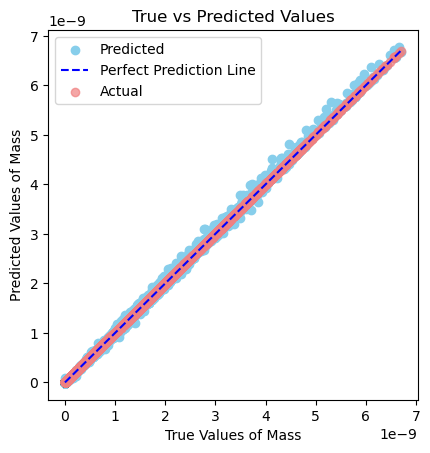

In [60]:
fig, ax = plt.subplots()
# Scatter plot for actual vs predicted
plt.scatter(y_test, y_pred_mlp, color='#87CEEB', label='Predicted')  # Light blue for predicted
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Perfect Prediction Line')  # Blue dashed line

# Scatter plot for actual vs actual
plt.scatter(y_test, y_test, color='lightcoral', label='Actual', alpha=0.7)  # Light red for actual, with transparency

ax.set_box_aspect(1)
plt.xlabel('True Values of Mass')
plt.ylabel('Predicted Values of Mass')
plt.title('True vs Predicted Values')
plt.legend()  # Show legend

plt.show()

In [14]:
results = pd.DataFrame({
    'actual_mass': y_test.flatten(),
    'predicted_mass': y_pred_mlp.flatten()
})

results

actual_mass  predicted_mass
0      4.600479e-11    4.359246e-11
1      3.457063e-10    3.476314e-10
2      1.726697e-11    1.281700e-11
3      1.585594e-12   -1.228564e-12
4      5.738096e-12    3.431620e-12
...             ...             ...
69435  3.954896e-11    3.506948e-11
69436  1.711021e-13   -5.997864e-13
69437  2.882138e-12    2.139151e-12
69438  2.706332e-11    2.153249e-11
69439  2.904455e-11    2.547689e-11

[69440 rows x 2 columns]

# Multiple Environmental Features

## Predict Change of Mass

In [9]:
x_train = train_df[['RH_ice', 'Mass of Particle (kg/m^2)', 'T [K]', 'prs', 'radius_eq(ice)[m]', 'rhod [kg/m3]']]
y_train = train_df['Change in Mass']

x_test = test_df[['RH_ice', 'Mass of Particle (kg/m^2)', 'T [K]', 'prs', 'radius_eq(ice)[m]', 'rhod [kg/m3]']]
y_test = test_df['Change in Mass']

In [10]:
mlp = MLPRegressor(random_state=666, max_iter=500, hidden_layer_sizes=(100, 50, 20))

# Reshape y_train and y_test to be 2D arrays if they are not already
y_train = y_train.values.reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test.reshape(-1, 1)

#Standardizing Y
y_scaler = StandardScaler().fit(y_train)

# make pipeline with input standardization
pipe = make_pipeline(StandardScaler(), mlp) 
pipe.fit(x_train, y_scaler.transform(y_train).ravel())

y_pred_mlp_scaled = pipe.predict(x_test) # these predictions are standardized
y_pred_mlp = y_scaler.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1)) # "un-standardize" back to original y scaling

In [11]:
mse = np.mean((y_test - y_pred_mlp)**2)
mae = np.mean(np.abs(y_test - y_pred_mlp))

ss_total = np.sum((y_test - np.mean(y_test))**2)
ss_residual = np.sum((y_test - y_pred_mlp)**2)
r2 = 1 - (ss_residual / ss_total)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 7.291771633886978e-23
Mean Absolute Error (MAE): 1.5614847473439045e-12
R-squared (R²): 0.9479342472463868


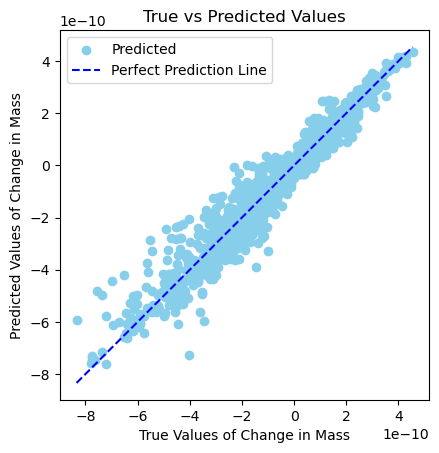

In [12]:
fig, ax = plt.subplots()
# Scatter plot for actual vs predicted
plt.scatter(y_test, y_pred_mlp, color='#87CEEB', label='Predicted')  # Light blue for predicted
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Perfect Prediction Line')  # Blue dashed line

ax.set_box_aspect(1)
plt.xlabel('True Values of Change in Mass')
plt.ylabel('Predicted Values of Change in Mass')
plt.title('True vs Predicted Values')
plt.legend()  # Show legend

plt.show()

In [20]:
# Assuming trajs is your DataFrame containing relevant columns
# heat_map_trajs = df
# columns_to_plot = ['RH_ice', 'Mass of Particle (kg/m^2)', 'T [K]', 'prs', 'radius_eq(ice)[m]', 'rhod [kg/m3]', 'qv', 'Change in Mass', 'Change in Radius (Equatorial)']
# correlation_matrix = heat_map_trajs[columns_to_plot].corr()

# plt.figure(figsize=(10, 8))

# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Heatmap')
# plt.show()

# Specify columns to plot
columns_to_plot = ['RH_ice', 'Mass of Particle (kg/m^2)', 'T [K]', 'prs', 'radius_eq(ice)[m]', 'rhod [kg/m3]', 'Change in Mass', 'Change in Radius (Equatorial)']

# Calculate the correlation matrix
correlation_matrix = df[columns_to_plot].corr()

# Define a dictionary for new labels
label_mapping = {
    'RH_ice': 'Relative Humidity',
    'Mass of Particle (kg/m^2)': 'Particle Mass',
    'T [K]': 'Temperature (K)',
    'prs': 'Pressure',
    'radius_eq(ice)[m]': 'Equatorial Radius',
    'rhod [kg/m3]': 'Density',
    'Change in Mass': 'Δ Mass',
    'Change in Radius (Equatorial)': 'Δ Radius'
}

# Create lists of new labels in the order of columns_to_plot
new_labels = [label_mapping[col] for col in columns_to_plot]

# Create the heatmap
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Set new labels
heatmap.set_yticklabels(new_labels, rotation=0)
heatmap.set_xticklabels(new_labels, rotation=45, ha='right')

plt.title('Correlation Heatmap')
plt.show()

In [22]:
residuals = y_test - y_pred_mlp

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_mlp, residuals, alpha=0.7, color='red')
plt.hlines(0, xmin=y_pred_mlp.min(), xmax=y_pred_mlp.max(), colors='black', linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

## Radius & Mass

In [8]:
x_train = train_df[['RH_ice', 'Mass of Particle (kg/m^2)', 'T [K]', 'prs', 'radius_eq(ice)[m]', 'rhod [kg/m3]']]
y_train = train_df[['Change in Mass', 'Change in Radius (Equatorial)']]

x_test = test_df[['RH_ice', 'Mass of Particle (kg/m^2)', 'T [K]', 'prs', 'radius_eq(ice)[m]', 'rhod [kg/m3]']]
y_test = test_df[['Change in Mass', 'Change in Radius (Equatorial)']]

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (277620, 6)
y_train shape: (277620, 2)
x_test shape: (69440, 6)
y_test shape: (69440, 2)


In [11]:
mlp = MLPRegressor(random_state=666, max_iter=500, hidden_layer_sizes=(100, 50, 20))

print(f"Reshaped y_train shape: {y_train.shape}")
print(f"Reshaped y_test shape: {y_test.shape}")

# Standardize features
x_scaler = StandardScaler().fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

# Standardize targets
y_scaler = StandardScaler().fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

#Standardizing Y
# y_scaler = StandardScaler().fit(y_train)

# make pipeline with input standardization
# pipe = make_pipeline(StandardScaler(), mlp) 
# pipe.fit(x_train, y_scaler.transform(y_train).ravel())

pipe = make_pipeline(StandardScaler(), mlp)
pipe.fit(x_train, y_train_scaled)

filename = 'mlp_single_model.joblib'
joblib.dump(pipe, filename)
loaded_model = joblib.load(filename)

y_pred_mlp_scaled = pipe.predict(x_test) # these predictions are standardized
y_pred_mlp = y_scaler.inverse_transform(y_pred_mlp_scaled.reshape(-2, 2)) # "un-standardize" back to original y scaling

Reshaped y_train shape: (277620, 2)
Reshaped y_test shape: (69440, 2)


/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [12]:
# mse = np.mean((y_test - y_pred_mlp)**2)
# mae = np.mean(np.abs(y_test - y_pred_mlp))

# ss_total = np.sum((y_test - np.mean(y_test))**2)
# ss_residual = np.sum((y_test - y_pred_mlp)**2)
# r2 = 1 - (ss_residual / ss_total)
mse = mean_squared_error(y_test, y_pred_mlp, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_pred_mlp, multioutput='raw_values')
r2 = r2_score(y_test, y_pred_mlp, multioutput='raw_values')

for i, col in enumerate(y_test.columns):
    print(f"Metrics for {col}:")
    print(f"  Mean Squared Error (MSE): {mse[i]}")
    print(f"  Mean Absolute Error (MAE): {mae[i]}")
    print(f"  R-squared (R²): {r2[i]}")

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Metrics for Change in Mass:
  Mean Squared Error (MSE): 8.163914841170507e-23
  Mean Absolute Error (MAE): 1.8078140518808607e-12
  R-squared (R²): 0.941706845336933
Metrics for Change in Radius (Equatorial):
  Mean Squared Error (MSE): 2.4983919161018545e-13
  Mean Absolute Error (MAE): 2.0221405429677843e-07
  R-squared (R²): 0.8836809364467305
Mean Squared Error (MSE): [8.16391484e-23 2.49839192e-13]
Mean Absolute Error (MAE): [1.80781405e-12 2.02214054e-07]
R-squared (R²): [0.94170685 0.88368094]


In [13]:
actual_output1 = y_test['Change in Mass']
actual_output2 = y_test['Change in Radius (Equatorial)'] * 1e-4

predicted_output1 = y_pred_mlp[:, 0]  # Assuming y_pred_mlp has two columns
predicted_output2 = y_pred_mlp[:, 1] * 1e-4

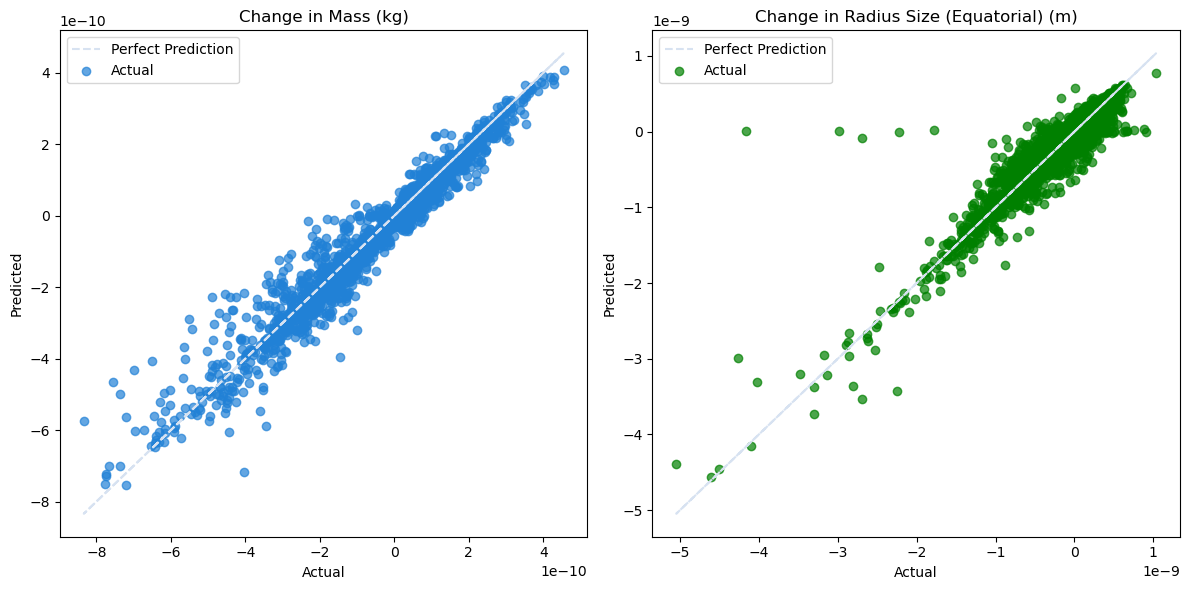

In [28]:
# Plot for Output 1
plt.figure(figsize=(12, 6))  # Adjust width and height as needed

plt.subplot(1, 2, 1)
plt.plot(actual_output1, actual_output1, color='#D7E2F1', linestyle='--', label='Perfect Prediction')
plt.scatter(actual_output1, predicted_output1, color='#2181D6', marker='o', label='Actual', alpha=0.7)
plt.title('Change in Mass (kg)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Plot for Output 2
plt.subplot(1, 2, 2)
plt.plot(actual_output2, actual_output2, color='#D7E2F1', linestyle='--', label='Perfect Prediction')
plt.scatter(actual_output2, predicted_output2, color='green', marker='o', label='Actual', alpha=0.7)
plt.title('Change in Radius Size (Equatorial) (m)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.tight_layout()
plt.show()

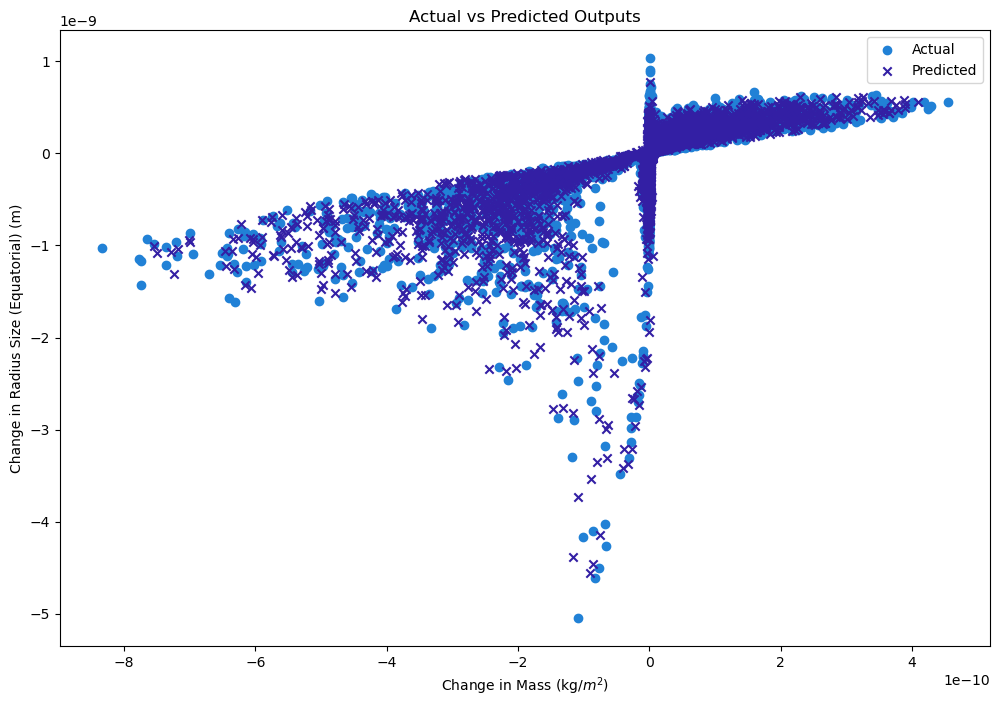

In [89]:
plt.figure(figsize=(12, 8))
plt.scatter(actual_output1, actual_output2, color='#2181D6', marker='o', label='Actual')
plt.scatter(predicted_output1, predicted_output2, color='#331FA4', marker='x', label='Predicted')
plt.title('Actual vs Predicted Outputs')
plt.xlabel('Change in Mass (kg/$m^{2}$)')
plt.ylabel('Change in Radius Size (Equatorial) (m)')
plt.legend()
plt.show()

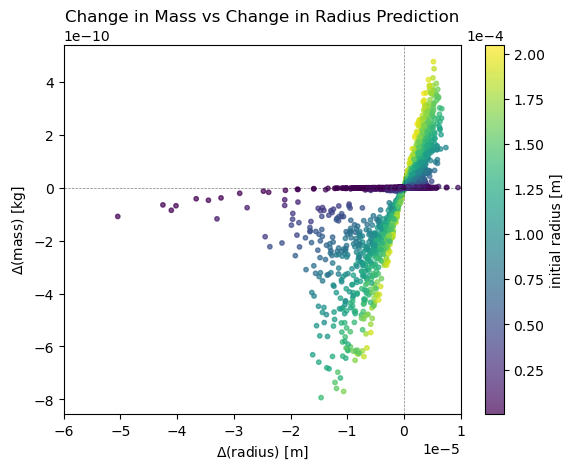

In [51]:
n_samples = 50000
df_subset = df.sample(n_samples)
ax = df_subset.plot.scatter('Change in Radius (Equatorial)', 'Change in Mass', c='radius_eq(ice)[m]_1', 
                     alpha=0.7, xlim=(-6e-5, 1e-5), s=10)
plt.title('Change in Mass vs Change in Radius Prediction')
ax.set_xlabel(r'$\Delta$(radius) [m]')
ax.set_ylabel(r'$\Delta$(mass) [kg]')
ax.collections[0].colorbar.set_label(r'initial radius [m]') # label colorbar
ax.collections[0].colorbar.formatter.set_powerlimits((0, 0)) # change colorbar to scientific notation
ax.axhline(linestyle='--', linewidth=0.5, alpha=0.5, color='black')
ax.axvline(linestyle='--', linewidth=0.5, alpha=0.5, color='black')

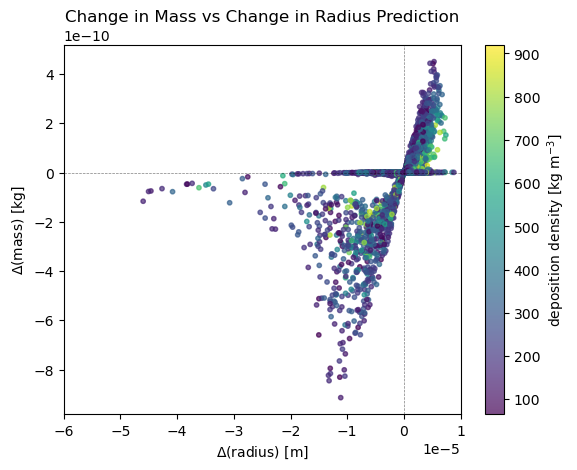

In [52]:
# Plot change in mass vs. change in radius, colored by deposition density
n_samples = 50000
df_subset = df.sample(n_samples)
ax = df_subset.plot.scatter('Change in Radius (Equatorial)', 'Change in Mass', c='rhod [kg/m3]_1', 
                     alpha=0.7, xlim=(-6e-5, 1e-5), s=10)
plt.title('Change in Mass vs Change in Radius Prediction')
ax.set_xlabel(r'$\Delta$(radius) [m]')
ax.set_ylabel(r'$\Delta$(mass) [kg]')
ax.collections[0].colorbar.set_label(r'deposition density [kg $\mathrm{m^{-3}}$]') # label colorbar
ax.axhline(linestyle='--', linewidth=0.5, alpha=0.5, color='black')
ax.axvline(linestyle='--', linewidth=0.5, alpha=0.5, color='black')

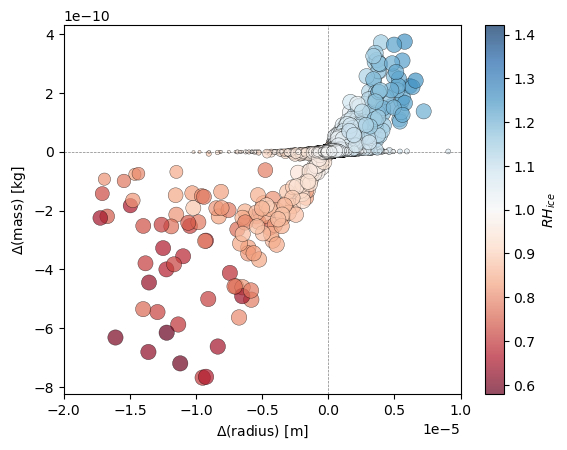

In [45]:
'''
Plot change in mass vs. change in radius
color by relative humidity w.r.t. ice
size by initial radius
Quantile transform + minmax scaling applied to radius
'''
n_samples = 10000
df_subset = df.sample(n_samples, random_state=666)
marker_min = 5
marker_max = 125
scaler = MinMaxScaler((marker_min, marker_max))
quant_transform = QuantileTransformer()
edge_color = colors.colorConverter.to_rgba('black', alpha=0.1)
marker_sizes = quant_transform.fit_transform(df_subset[['radius_eq(ice)[m]_1']])
marker_sizes = scaler.fit_transform(marker_sizes)
ax = df_subset.plot.scatter('Change in Radius (Equatorial)', 'Change in Mass', c='RH_ice_1', 
                            alpha=0.7, xlim=(-2e-5, 1e-5), s=marker_sizes, 
                            colormap='RdBu', norm=colors.CenteredNorm(1.0),
                            edgecolors=edge_color, linewidth=0.3)
ax.set_xlabel(r'$\Delta$(radius) [m]')
ax.set_ylabel(r'$\Delta$(mass) [kg]')
ax.collections[0].colorbar.set_label(r'$RH_{ice}$') # label colorbar
ax.axhline(linestyle='--', linewidth=0.5, alpha=0.5, color='black')
ax.axvline(linestyle='--', linewidth=0.5, alpha=0.5, color='black')

## SHAP

In [19]:
# SHAP analysis

if isinstance(x_train_scaled, np.ndarray):
    copy_x_train = pd.DataFrame(x_train_scaled)
    print(copy_x_train)
if isinstance(x_test_scaled, np.ndarray):
    copy_x_test = pd.DataFrame(x_test_scaled)
    
n_shap_samples = 5000
n_background = 50
n_clusters = 5
# background = shap.kmeans(X_train_scaled, n_clusters) # can use this as background for larger datasets
background = copy_x_train.sample(n_background) # background dataset (https://stackoverflow.com/questions/72309555/purpose-of-background-dataset-for-shap-library-deep-explainer)
explainer = shap.KernelExplainer(mlp.predict, copy_x_train.sample(50))
shap_values = explainer(x_test_scaled.sample(n_shap_samples))
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0)) # beeswarm plot

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

## Single Step Pred Roll-Out

In [18]:
final_df

rk_deact  RH_ice_5100  RH_ice_5160  RH_ice_5220  RH_ice_5280  \
0          13957     0.999829     0.997001     0.994896     1.001331   
1         150328     1.004059     1.000650     1.025424     1.022612   
2         206362     1.003851     1.003703     1.004780     1.004460   
3         207674     1.016085     1.017993     1.020512     1.022408   
4         218111     1.001944     1.001454     1.001299     1.001556   
...          ...          ...          ...          ...          ...   
9911  1015230609     1.012503     1.012161     0.997966     0.997798   
9912  1015266378     1.001228     1.001551     1.006561     1.006907   
9913  1015305678     1.043008     1.036956     1.089560     1.072873   
9914  1015329135     1.011629     1.016430     1.044236     1.037085   
9915  1015454933     1.021572     1.021561     1.021626     1.021943   

      RH_ice_5340  RH_ice_5400  RH_ice_5460  RH_ice_5520  RH_ice_5580  ...  \
0        1.001797     1.004567     1.010012     1.016878     1.022533  ...   
1        1.025471     1.026627     1.015425     1.017058     0.992287  ...   
2        1.003884     1.003134     1.002857     1.002755     1.005830  ...   
3        1.024251     1.026633     1.026577     1.058225     1.041028  ...   
4        1.010182     1.012530     1.003763     1.006106     1.008460  ...   
...           ...          ...          ...          ...          ...  ...   
9911     0.999396     0.999020     0.999200     0.998275     1.007271  ...   
9912     1.003416     1.004924     1.005237     1.005599     1.005350  ...   
9913     1.057628     1.044012     1.032875     1.023187     1.015817  ...   
9914     1.034118     1.030701     1.023573     1.016679     1.012398  ...   
9915     1.022779     1.024848     0.994576     1.003411     1.005307  ...   

      rhod [kg/m3]_6660  rhod [kg/m3]_6720  rhod [kg/m3]_6780  \
0                419.09             419.09             419.09   
1                358.64             358.64             358.64   
2                211.82             211.82             211.82   
3                298.18             298.18             298.18   
4                332.73             332.73             332.73   
...                 ...                ...                ...   
9911             142.73             142.73             142.73   
9912             194.55             194.55             194.55   
9913             203.18             203.18             203.18   
9914              82.27              82.27              82.27   
9915             393.18             393.18             393.18   

      rhod [kg/m3]_6840  rhod [kg/m3]_6900  rhod [kg/m3]_6960  \
0                419.09             419.09             419.09   
1                358.64             358.64             358.64   
2                211.82             211.82             211.82   
3                298.18             298.18             298.18   
4                332.73             332.73             332.73   
...                 ...                ...                ...   
9911             142.73             142.73             142.73   
9912             194.55             194.55             194.55   
9913             203.18             203.18             203.18   
9914              82.27              82.27              82.27   
9915             393.18             393.18             393.18   

      rhod [kg/m3]_7020  rhod [kg/m3]_7080  rhod [kg/m3]_7140  \
0                419.09             419.09             419.09   
1                358.64             358.64             358.64   
2                211.82             211.82             211.82   
3                298.18             298.18             298.18   
4                332.73             332.73             332.73   
...                 ...                ...                ...   
9911             142.73             142.73             142.73   
9912             194.55             194.55             194.55   
9913             203.18             203.18             203.

In [34]:
# Calculate the change of mass between consecutive timesteps
timesteps = list(dict_columns.keys())
for time_idx in range(len(timesteps) - 1):
    t1 = timesteps[time_idx]
    t2 = timesteps[time_idx + 1]
    mass_col_t1 = f'Mass of Particle (kg/m^2)_{t1}'
    mass_col_t2 = f'Mass of Particle (kg/m^2)_{t2}'
    
    # Calculate change in mass
    final_df[f'Change in Mass ({t1} to {t2})'] = final_df[mass_col_t2] - final_df[mass_col_t1]

# Calculate the change of radius between consecutive timesteps
radius_changes = {}
for time_idx in range(len(timesteps) - 1):
    t1 = timesteps[time_idx]
    t2 = timesteps[time_idx + 1]
    radius_col_t1 = f'radius_eq(ice)[m]_{t1}'
    radius_col_t2 = f'radius_eq(ice)[m]_{t2}'
    
    # Calculate change in radius
    final_df[f'Change in Radius ({t1} to {t2})'] = final_df[radius_col_t2] - final_df[radius_col_t1]

In [35]:
# Train and Test Split
unique_ids = final_df['rk_deact'].unique()

train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state = 666)

# Filter the original dataframe to create train and test sets
train_multi_df = final_df[final_df['rk_deact'].isin(train_ids)]
test_multi_df = final_df[final_df['rk_deact'].isin(test_ids)]

# Display the shapes of the resulting DataFrames to ensure the split
print("Train DataFrame shape:", train_multi_df.shape)
print("Test DataFrame shape:", test_multi_df.shape)

Train DataFrame shape: (7932, 287)
Test DataFrame shape: (1984, 287)


In [36]:
test_multi_df

rk_deact  RH_ice_5100  RH_ice_5160  RH_ice_5220  RH_ice_5280  \
3         207674     1.016085     1.017993     1.020512     1.022408   
10        643543     1.014993     1.004466     0.996648     1.047426   
15       1112829     1.004977     1.024496     1.008946     1.009482   
18       1245623     0.996172     0.996031     0.989637     0.992950   
36       2787287     1.016500     1.015319     1.014726     1.017414   
...          ...          ...          ...          ...          ...   
9891  1013400131     1.020239     1.005924     1.006985     1.008869   
9897  1014216823     1.000079     1.000309     1.000058     1.001648   
9899  1014346140     1.001054     1.024272     1.021077     1.022580   
9900  1014456914     0.998531     0.997691     0.997331     0.995966   
9904  1014771971     1.025898     1.016150     0.994989     0.990667   

      RH_ice_5340  RH_ice_5400  RH_ice_5460  RH_ice_5520  RH_ice_5580  ...  \
3        1.024251     1.026633     1.026577     1.058225     1.041028  ...   
10       1.029874     1.019944     1.014081     1.010528     1.007995  ...   
15       1.009818     1.012174     1.019552     1.017455     1.015104  ...   
18       0.985886     0.988406     0.989538     1.013567     1.011602  ...   
36       1.012504     0.992918     0.998331     0.999205     1.000038  ...   
...           ...          ...          ...          ...          ...  ...   
9891     1.011565     1.015041     1.021370     1.026959     1.032703  ...   
9897     1.001842     1.001735     1.007896     1.006404     1.005172  ...   
9899     1.018811     1.016710     1.004107     1.003396     1.025160  ...   
9900     0.994387     0.991891     0.996789     0.991734     1.011773  ...   
9904     1.000914     1.000379     0.996652     0.994621     0.994032  ...   

      Change in Radius (6600 to 6660)  Change in Radius (6660 to 6720)  \
3                        3.503480e-07                     2.283320e-07   
10                       1.403972e-06                     1.543624e-06   
15                      -4.395870e-07                    -2.546070e-07   
18                       1.767712e-07                     1.992220e-07   
36                      -3.222538e-08                    -8.790907e-08   
...                               ...                              ...   
9891                     9.593600e-08                     9.093500e-08   
9897                    -1.031700e-06                    -1.152743e-06   
9899                    -6.019580e-07                    -7.342740e-07   
9900                     1.000044e-06                     8.899980e-07   
9904                    -4.487940e-07                    -3.387470e-07   

      Change in Radius (6720 to 6780)  Change in Radius (6780 to 6840)  \
3                        1.296810e-07                     9.148700e-08   
10                       1.565053e-06                     1.777635e-06   
15                      -2.308210e-07                    -3.381300e-08   
18                       2.260212e-06                     3.122427e-06   
36                       0.000000e+00                     0.000000e+00   
...                               ...                              ...   
9891                     9.278100e-08                     3.525760e-07   
9897                    -1.174530e-06                    -8.678039e-07   
9899                    -7.417570e-07                    -9.593820e-07   
9900                     5.845340e-07                     1.660310e-07   
9904                    -2.993740e-07                    -3.461030e-07   

      Change in Radius (6840 to 6900)  Change in Radius (6900 to 6960)  \
3                        8.978300e-08                     1.339890e-07   
10                       1.837649e-06                     2.097825e-06   
15                       1.929460e-07                     1.422640e-07   
18                       2.496410e-06                     2.019025e-06   
36                       0.000000e+00                     

In [37]:
# Original Dataframe
#Splitting data into training and testing datasets
unique_ids = df['rk_deact'].unique()

train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state = 666)

# Filter the original dataframe to create train and test sets
train_df = df[df['rk_deact'].isin(train_ids)]
test_df = df[df['rk_deact'].isin(test_ids)]

# Display the shapes of the resulting DataFrames to ensure the split
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (277620, 86)
Test DataFrame shape: (69440, 86)


In [22]:
#Get x and y scaler
x_train = train_df[['RH_ice', 'Mass of Particle (kg/m^2)', 'T [K]', 'prs', 'radius_eq(ice)[m]', 'rhod [kg/m3]']]
y_train = train_df[['Change in Mass', 'Change in Radius (Equatorial)']]

x_scaler = StandardScaler().fit(x_train)
y_scaler = StandardScaler().fit(y_train)

In [ ]:
#Dictionary to assign each unique time step with its corresponding columns
def extract_timesteps(columns):
    timestep_dict = {}
    for col in columns:
        match = re.search(r'_(\d+)$', col)
        if match:
            timestep = match.group(1)
            if timestep not in timestep_dict:
                timestep_dict[timestep] = []
            timestep_dict[timestep].append(col)
    return timestep_dict

dict_columns = extract_timesteps(test_multi_df.columns)
dict_columns

In [24]:
# Double check
specific_timestep = '5100'
input_columns = dict_columns['5100']
input_values = test_multi_df[input_columns].values
print(f'Columns for timestep {specific_timestep}: {input_columns}')
print(f'Values for timestep {specific_timestep}:\n{input_values}')

data = test_multi_df[input_columns].values.tolist()
    
# Convert the list of values to a DataFrame
time_check_df = pd.DataFrame(data, columns=input_columns)
time_check_df

Columns for timestep 5100: ['RH_ice_5100', 'Mass of Particle (kg/m^2)_5100', 'T [K]_5100', 'prs_5100', 'radius_eq(ice)[m]_5100', 'rhod [kg/m3]_5100']
Values for timestep 5100:
[[1.01608499e+00 4.46269959e-11 2.32073827e+02 3.05257793e+04
  3.29357960e-05 2.98180000e+02]
 [1.01499281e+00 3.43874319e-10 2.32886115e+02 3.09775449e+04
  7.43178420e-05 6.50000000e+01]
 [1.00497692e+00 1.61278904e-11 2.31212311e+02 3.00789414e+04
  2.22401160e-05 3.50000000e+02]
 ...
 [1.00105380e+00 7.81457987e-12 2.29301021e+02 2.91995645e+04
  1.38644270e-05 8.33640000e+02]
 [9.98530968e-01 1.57936835e-11 2.29242318e+02 2.91995371e+04
  2.66138460e-05 1.42730000e+02]
 [1.02589782e+00 2.99494555e-11 2.29334152e+02 2.91996172e+04
  2.55680990e-05 4.27730000e+02]]


RH_ice_5100  Mass of Particle (kg/m^2)_5100  T [K]_5100      prs_5100  \
0        1.016085                    4.462700e-11  232.073827  30525.779297   
1        1.014993                    3.438743e-10  232.886115  30977.544922   
2        1.004977                    1.612789e-11  231.212311  30078.941406   
3        0.996172                    1.769873e-12  230.211913  29636.873047   
4        1.016500                    5.299268e-12  229.360026  29199.544922   
...           ...                             ...         ...           ...   
1979     1.020239                    1.205678e-11  231.209328  30078.933594   
1980     1.000079                    2.923483e-12  229.280150  29199.599609   
1981     1.001054                    7.814580e-12  229.301021  29199.564453   
1982     0.998531                    1.579368e-11  229.242318  29199.537109   
1983     1.025898                    2.994946e-11  229.334152  29199.617188   

      radius_eq(ice)[m]_5100  rhod [kg/m3]_5100  
0                   0.000033             298.18  
1                   0.000074              65.00  
2                   0.000022             350.00  
3                   0.000009             496.82  
4                   0.000017             272.27  
...                      ...                ...  
1979                0.000021             332.73  
1980                0.000015              90.91  
1981                0.000014             833.64  
1982                0.000027             142.73  
1983                0.000026             427.73  

[1984 rows x 6 columns]

### Predicting the Mass and Radius

In [68]:
#Iteration to iterate through the dictionary
# unique_times = np.unique(trajs['time'])
all_updated_values = []

# Initialize lists to store actual and predicted values for plotting
all_actual_mass = []
all_predicted_mass = []
all_actual_radius = []
all_predicted_radius = []
time_labels = []

metrics_mass = {'MSE': [], 'MAE': [], 'R2': []}
metrics_radius = {'MSE': [], 'MAE': [], 'R2': []}

#iterates through every key timestep
for i, time in enumerate(dict_columns):
    columns_of_time = dict_columns[time]
    # input = test_multi_df[columns_of_time].values

    # Extract mass and radius columns for the current timestep
    mass_col = f'Mass of Particle (kg/m^2)_{time}'
    radius_col = f'radius_eq(ice)[m]_{time}'
    current_mass = test_multi_df[mass_col].values
    current_radius = test_multi_df[radius_col].values
    
    # If it's the first timestep, use the actual data
    if i == 0:
        input = test_multi_df[columns_of_time].values
    else:
        # Replace the actual mass and radius with the predicted values
        input[:, columns_of_time.index(mass_col)] = previous_predicted_mass
        input[:, columns_of_time.index(radius_col)] = previous_predicted_radius
        
    # input_scaled = x_scaler.transform(input)
    output_scaled = loaded_model.predict(input)
    output = y_scaler.inverse_transform(output_scaled.reshape(-2, 2)) # "un-standardize" back to original y scaling
    
    # Assuming the output is [change_of_mass, change_of_radius]
    change_of_mass = output[:, 0]
    change_of_radius = output[:, 1]
    
    predicted_mass = current_mass + change_of_mass
    predicted_radius = current_radius + change_of_radius

    # Store the predicted values for use in the next timestep
    previous_predicted_mass = predicted_mass
    previous_predicted_radius = predicted_radius
    
    predictions_df = pd.DataFrame({
        f'Actual Mass (kg/m^2)_{time}': current_mass,
        f'Predicted Mass (kg/m^2)_{time}': predicted_mass,
        f'Actual Radius (m)_{time}': current_radius,
        f'Predicted Radius (m)_{time}': predicted_radius
    }, index=test_multi_df.index)

    # Store actual and predicted values for plotting
    all_actual_mass.extend(current_mass)
    all_predicted_mass.extend(predicted_mass)
    all_actual_radius.extend(current_radius)
    all_predicted_radius.extend(predicted_radius)
    time_labels.extend([time] * len(current_mass))
    
    # Calculate metrics for the current timestep
    mse_mass = mean_squared_error(current_mass, predicted_mass)
    mae_mass = mean_absolute_error(current_mass, predicted_mass)
    r2_mass = r2_score(current_mass, predicted_mass)

    mse_radius = mean_squared_error(current_radius, predicted_radius)
    mae_radius = mean_absolute_error(current_radius, predicted_radius)
    r2_radius = r2_score(current_radius, predicted_radius)

    # Store metrics for the current timestep
    metrics_mass['MSE'].append((time, mse_mass))
    metrics_mass['MAE'].append((time, mae_mass))
    metrics_mass['R2'].append((time, r2_mass))

    metrics_radius['MSE'].append((time, mse_radius))
    metrics_radius['MAE'].append((time, mae_radius))
    metrics_radius['R2'].append((time, r2_radius))
    
    # Append the DataFrame to the list
    all_updated_values.append(predictions_df)

final_predictions_df = pd.concat(all_updated_values, axis=1)
final_predictions_df

/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  

Actual Mass (kg/m^2)_5100  Predicted Mass (kg/m^2)_5100  \
3                  4.462700e-11                  4.589796e-11   
10                 3.438743e-10                  3.470670e-10   
15                 1.612789e-11                  1.584283e-11   
18                 1.769873e-12                  1.556453e-12   
36                 5.299268e-12                  5.301394e-12   
...                         ...                           ...   
9891               1.205678e-11                  1.274661e-11   
9897               2.923483e-12                  2.871298e-12   
9899               7.814580e-12                  7.278890e-12   
9900               1.579368e-11                  1.533775e-11   
9904               2.994946e-11                  3.064359e-11   

      Actual Radius (m)_5100  Predicted Radius (m)_5100  \
3                   0.000033                   0.000033   
10                  0.000074                   0.000075   
15                  0.000022                   0.000022   
18                  0.000009                   0.000009   
36                  0.000017                   0.000017   
...                      ...                        ...   
9891                0.000021                   0.000021   
9897                0.000015                   0.000015   
9899                0.000014                   0.000014   
9900                0.000027                   0.000026   
9904                0.000026                   0.000026   

      Actual Mass (kg/m^2)_5160  Predicted Mass (kg/m^2)_5160  \
3                  4.600479e-11                  4.729706e-11   
10                 3.457063e-10                  3.489189e-10   
15                 1.726697e-11                  1.698999e-11   
18                 1.585594e-12                  1.363484e-12   
36                 5.738096e-12                  5.746386e-12   
...                         ...                           ...   
9891               1.212833e-11                  1.284965e-11   
9897               2.826877e-12                  2.762463e-12   
9899               8.458680e-12                  7.930597e-12   
9900               1.548476e-11                  1.503714e-11   
9904               3.061136e-11                  3.135233e-11   

      Actual Radius (m)_5160  Predicted Radius (m)_5160  \
3                   0.000033                   0.000034   
10                  0.000074                   0.000075   
15                  0.000023                   0.000023   
18                  0.000009                   0.000009   
36                  0.000017                   0.000018   
...                      ...                        ...   
9891                0.000021                   0.000021   
9897                0.000015                   0.000015   
9899                0.000015                   0.000015   
9900                0.000026                   0.000026   
9904                0.000026                   0.000027   

      Actual Mass (kg/m^2)_5220  Predicted Mass (kg/m^2)_5220  ...  \
3                  4.766755e-11                  4.897556e-11  ...   
10                 3.449971e-10                  3.482225e-10  ...   
15                 1.801297e-11                  1.778660e-11  ...   
18                 1.130305e-12                  8.968135e-13  ...   
36                 6.145338e-12                  6.159473e-12  ...   
...                         ...                           ...  ...   
9891               1.225868e-11                  1.298268e-11  ...   
9897               2.738744e-12                  2.655488e-12  ...   
9899               9.081770e-12                  8.550359e-12  ...   
9900               1.509546e-11                  1.465656e-11  ...   
9904               3.061527e-11                  3.138515e-11  ...   

      Actual Radius (m)_7080  Predicted Radius (m)_7080  \
3               4.697596e-05                   0.000047   
10              9.893991e-05                   0.000099   
15      

In [25]:
# Print metrics for each timestep
print("Metrics for Mass at each timestep:")
for metric, values in metrics_mass.items():
    print(f"{metric}:")
    for time, value in values:
        print(f"  Timestep {time}: {value}")

print("\nMetrics for Radius at each timestep:")
for metric, values in metrics_radius.items():
    print(f"{metric}:")
    for time, value in values:
        print(f"  Timestep {time}: {value}")

Metrics for Mass at each timestep:
MSE:
  Timestep 5100: 7.722232718896268e-22
  Timestep 5160: 8.557632677370012e-22
  Timestep 5220: 9.425733889420437e-22
  Timestep 5280: 1.0225669437709486e-21
  Timestep 5340: 1.1054515174784684e-21
  Timestep 5400: 1.1829473940170507e-21
  Timestep 5460: 1.2548136219864773e-21
  Timestep 5520: 1.3229607449180156e-21
  Timestep 5580: 1.3868480190585256e-21
  Timestep 5640: 1.4475832720722088e-21
  Timestep 5700: 1.495431911704286e-21
  Timestep 5760: 1.5339106422562511e-21
  Timestep 5820: 1.5533293466316677e-21
  Timestep 5880: 1.5507327807021396e-21
  Timestep 5940: 1.5211088228602906e-21
  Timestep 6000: 1.4670201223937763e-21
  Timestep 6060: 1.395271957166347e-21
  Timestep 6120: 1.3154172603051793e-21
  Timestep 6180: 1.2352427855547088e-21
  Timestep 6240: 1.1427696694748698e-21
  Timestep 6300: 1.0562513758412168e-21
  Timestep 6360: 9.707945065286085e-22
  Timestep 6420: 8.92397532745008e-22
  Timestep 6480: 8.223040271126215e-22
  Timeste

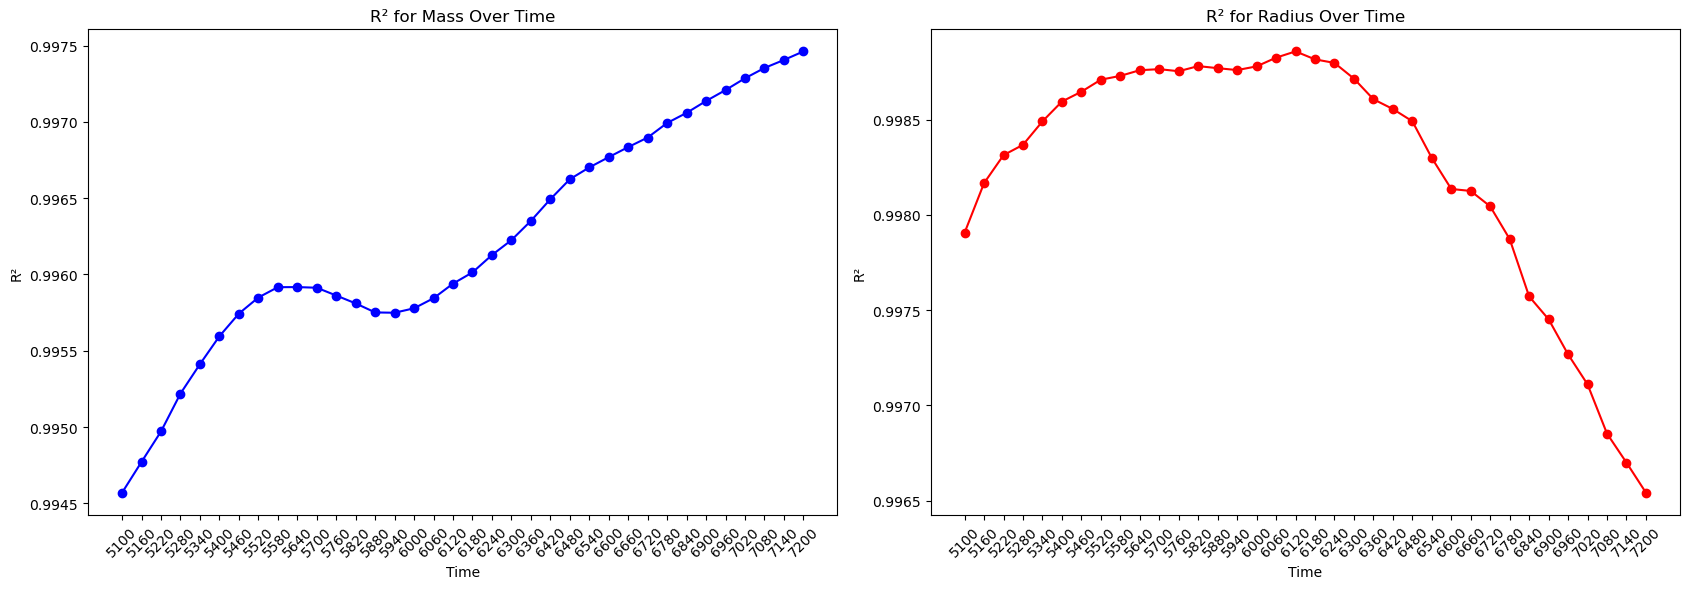

In [37]:
# Extract R2 values for plotting
times = [t for t, _ in metrics_mass['R2']]
r2_mass_values = [r2 for _, r2 in metrics_mass['R2']]
r2_radius_values = [r2 for _, r2 in metrics_radius['R2']]

# Plot R2 values
plt.figure(figsize=(17, 6))

plt.subplot(1, 2, 1)
plt.plot(times, r2_mass_values, marker='o', linestyle='-', color='b', label='R² Mass')
plt.xlabel('Time')
plt.ylabel('R²')
plt.title('R² for Mass Over Time')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(times, r2_radius_values, marker='o', linestyle='-', color='r', label='R² Radius')
plt.xlabel('Time')
plt.ylabel('R²')
plt.title('R² for Radius Over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

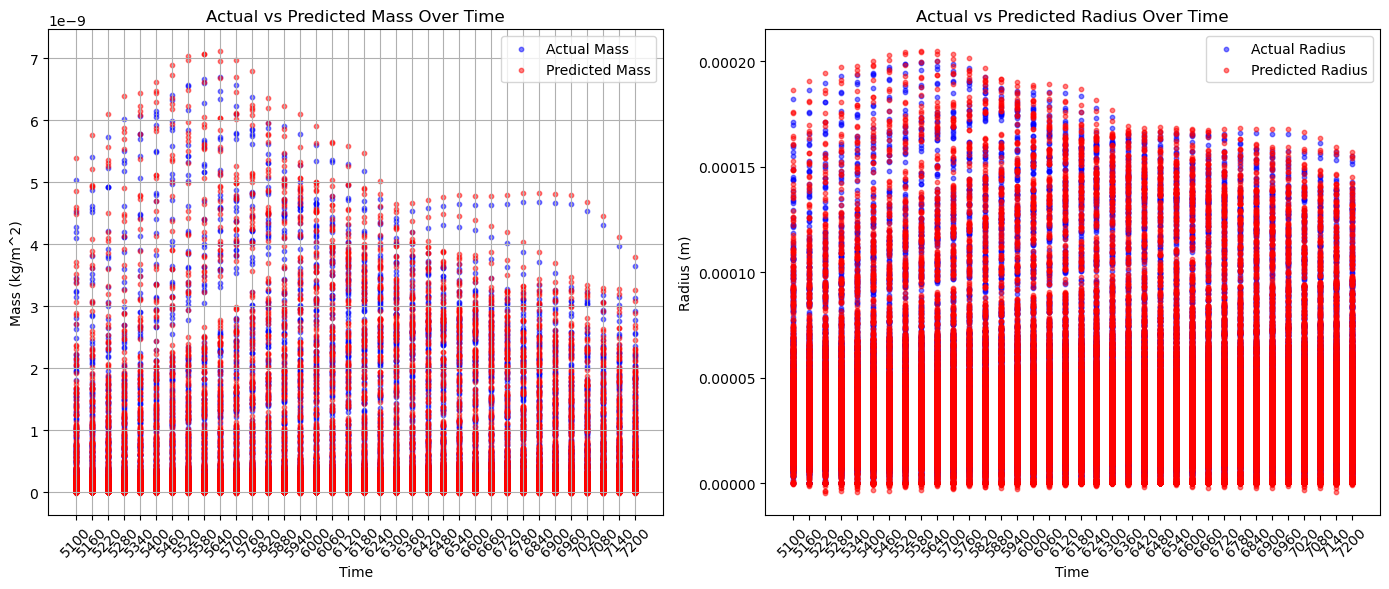

In [35]:
# Plot true vs. predicted values for mass
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(time_labels, all_actual_mass, label='Actual Mass', color='blue', alpha=0.5, s=10)
plt.scatter(time_labels, all_predicted_mass, label='Predicted Mass', color='red', alpha=0.5, s=10)
plt.xlabel('Time')
plt.ylabel('Mass (kg/m^2)')
plt.title('Actual vs Predicted Mass Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Plot true vs. predicted values for radius
plt.subplot(1, 2, 2)
plt.scatter(time_labels, all_actual_radius, label='Actual Radius', color='blue', alpha=0.5, s=10)
plt.scatter(time_labels, all_predicted_radius, label='Predicted Radius', color='red', alpha=0.5, s=10)
plt.xlabel('Time')
plt.ylabel('Radius (m)')
plt.title('Actual vs Predicted Radius Over Time')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

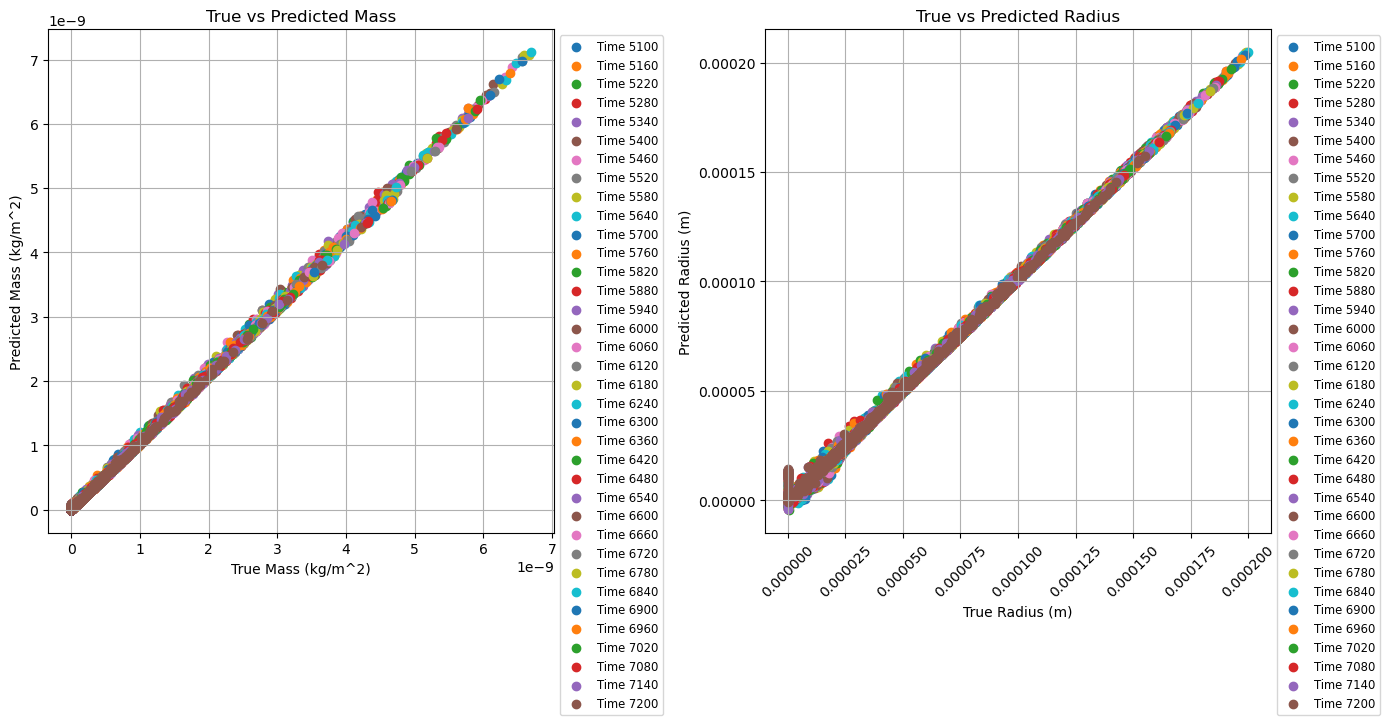

In [43]:
# Plotting true vs predicted for mass and radius side by side
plt.figure(figsize=(14, 7))  # Adjust width and height as needed

# Subplot for true vs predicted mass
plt.subplot(1, 2, 1)
for time in dict_columns:
    actual_mass_col = f'Actual Mass (kg/m^2)_{time}'
    predicted_mass_col = f'Predicted Mass (kg/m^2)_{time}'
    plt.scatter(final_predictions_df[actual_mass_col], final_predictions_df[predicted_mass_col], label=f'Time {time}')

plt.xlabel('True Mass (kg/m^2)')
plt.ylabel('Predicted Mass (kg/m^2)')
plt.title('True vs Predicted Mass')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')  # Adjust legend position
plt.grid(True)  # Add grid for better readability

# Subplot for true vs predicted radius
plt.subplot(1, 2, 2)
for time in dict_columns:
    actual_radius_col = f'Actual Radius (m)_{time}'
    predicted_radius_col = f'Predicted Radius (m)_{time}'
    plt.scatter(final_predictions_df[actual_radius_col], final_predictions_df[predicted_radius_col], label=f'Time {time}')

plt.xlabel('True Radius (m)')
plt.ylabel('Predicted Radius (m)')
plt.title('True vs Predicted Radius')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')  # Adjust legend position
plt.grid(True)  # Add grid for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

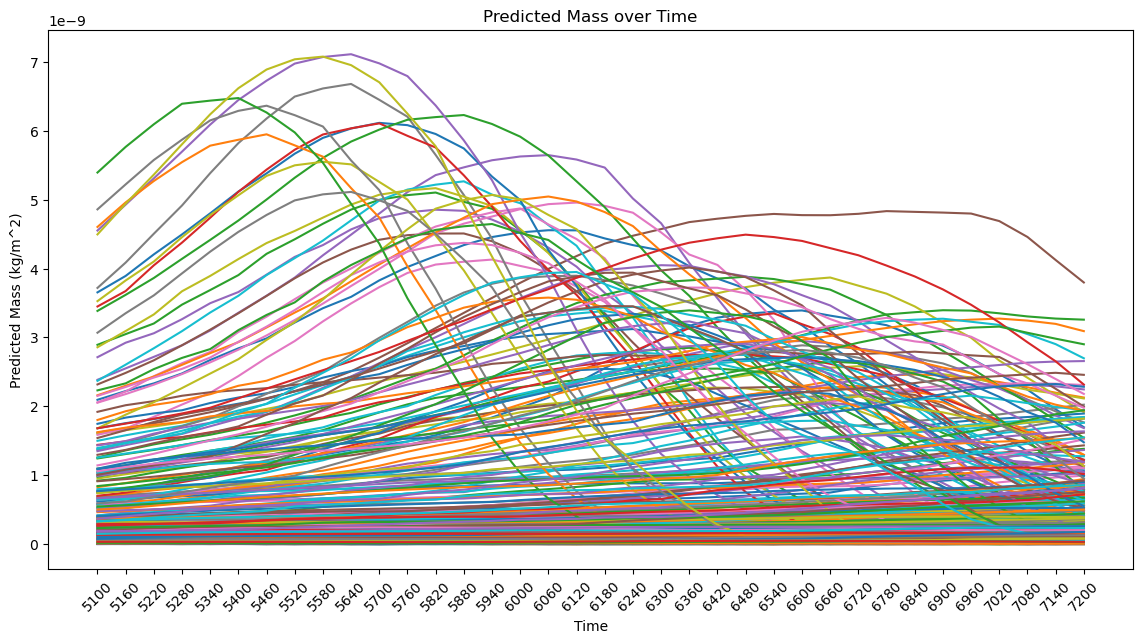

In [22]:
plt.figure(figsize=(14, 7))

# Iterate over each particle (row in the dataframe)
for index in final_predictions_df.index:
    predicted_masses = []
    times = []
    
    for time in dict_columns:
        predicted_mass_col = f'Predicted Mass (kg/m^2)_{time}'
        predicted_masses.append(final_predictions_df.loc[index, predicted_mass_col])
        times.append(time)
    
    plt.plot(times, predicted_masses, label=f'Particle {index}')
    
plt.xlabel('Time')
plt.ylabel('Predicted Mass (kg/m^2)')
plt.title('Predicted Mass over Time')
# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

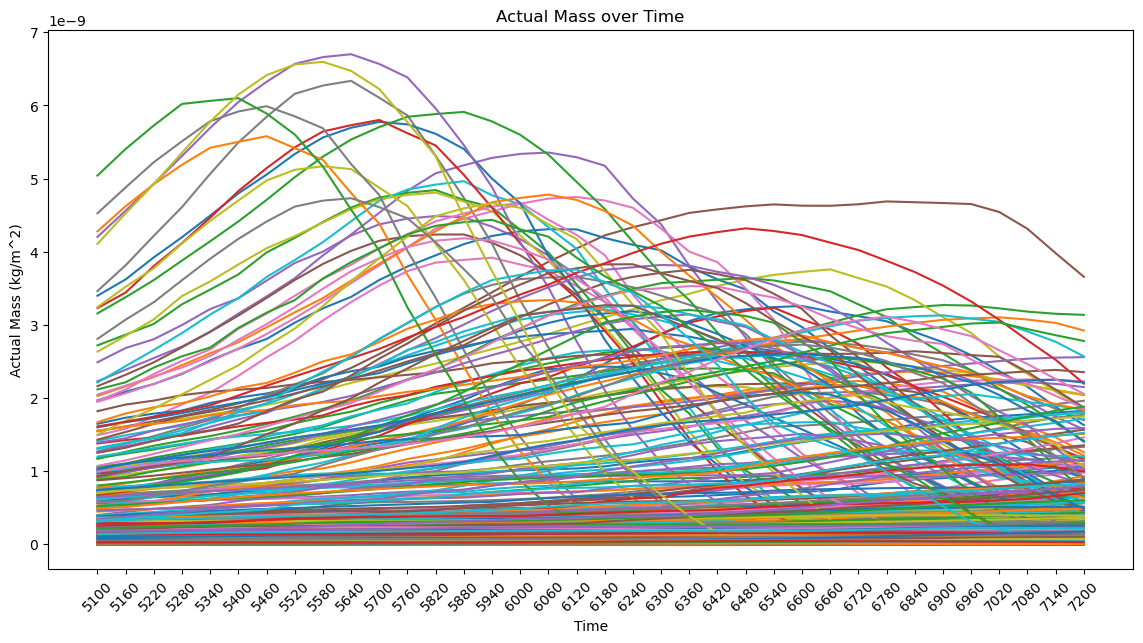

In [23]:
plt.figure(figsize=(14, 7))

# Iterate over each particle (row in the dataframe)
for index in final_predictions_df.index:
    actual_masses = []
    times = []
    
    for time in dict_columns:
        actual_mass_col = f'Actual Mass (kg/m^2)_{time}'
        actual_masses.append(final_predictions_df.loc[index, actual_mass_col])
        times.append(time)
    
    plt.plot(times, actual_masses, label=f'Particle {index}')
    
plt.xlabel('Time')
plt.ylabel('Actual Mass (kg/m^2)')
plt.title('Actual Mass over Time')
# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [47]:
# Create a subplot for actual and predicted mass over time
fig, ax = plt.subplots(figsize=(14, 7))  # Adjust the figure size as needed
selected_indices = final_predictions_df.index[:15]

# Plotting actual and predicted mass over time for each particle
ax.set_title('Actual and Predicted Mass over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Mass (kg/m^2)')

# Iterate over each selected particle (row in the dataframe)
for index in selected_indices:
    actual_masses = []
    predicted_masses = []
    times = []
    
    for time in dict_columns:
        actual_mass_col = f'Actual Mass (kg/m^2)_{time}'
        predicted_mass_col = f'Predicted Mass (kg/m^2)_{time}'
        actual_masses.append(final_predictions_df.loc[index, actual_mass_col])
        predicted_masses.append(final_predictions_df.loc[index, predicted_mass_col])
        times.append(time)
    
    # Plot actual masses with a solid line
    ax.plot(times, actual_masses, label=f'Particle {index} Actual', linestyle='-')
    
    # Plot predicted masses with a dashed line
    ax.plot(times, predicted_masses, label=f'Particle {index} Predicted', linestyle='--')

# Set x-ticks and rotate labels for better readability
ax.set_xticks(times)
ax.set_xticklabels(times, rotation=45)

# Add a legend to the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

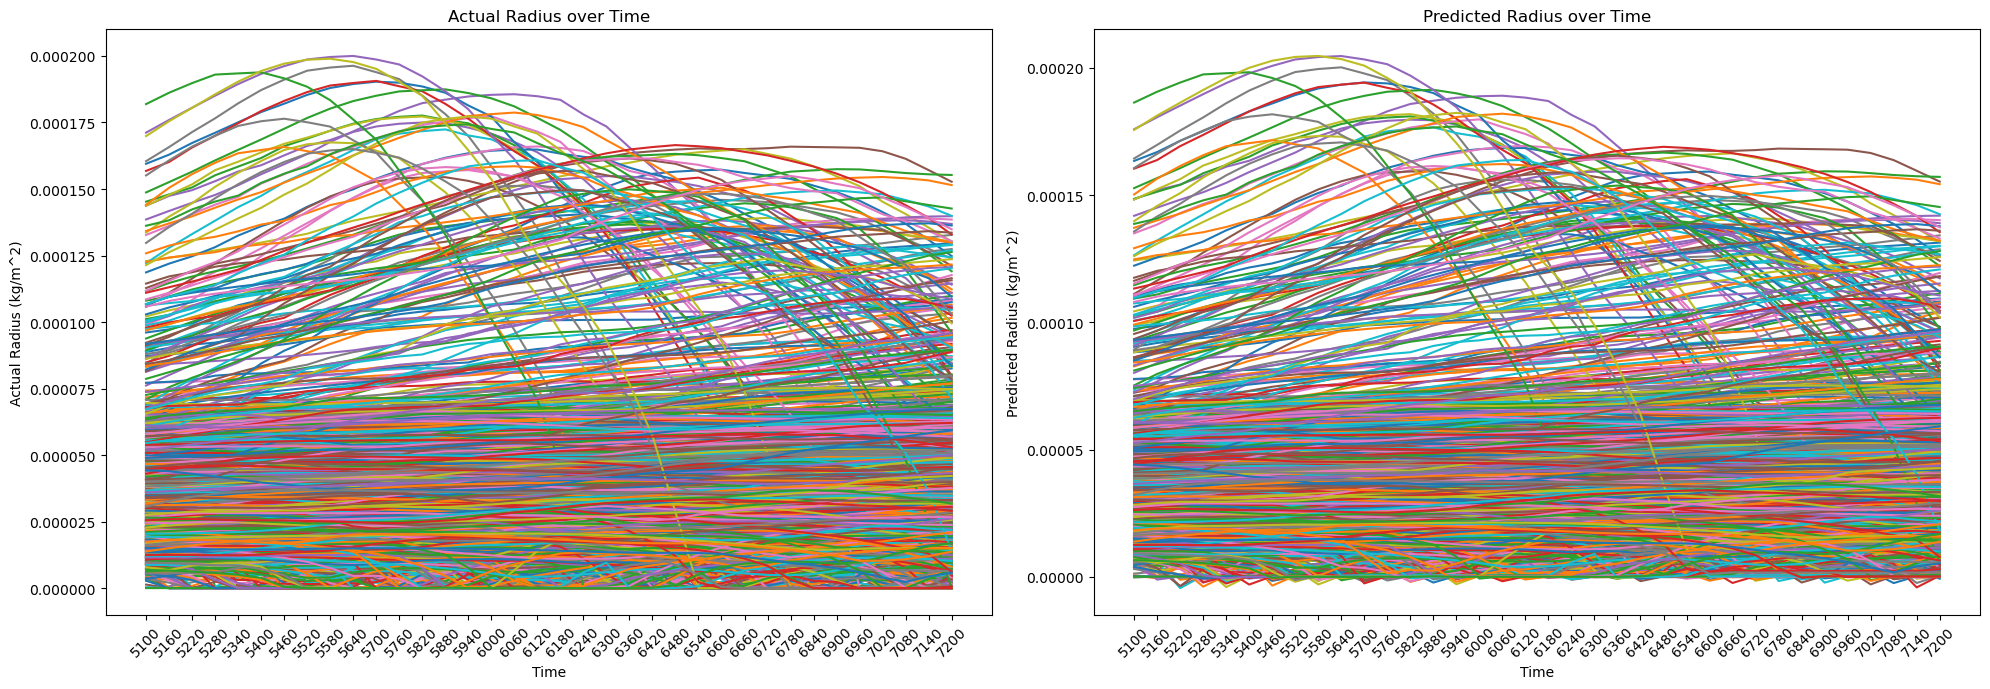

In [27]:
# Create subplots for actual and predicted mass over time
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plotting actual mass over time for each particle
axes[0].set_title('Actual Radius over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Actual Radius (kg/m^2)')

# Plotting predicted mass over time for each particle
axes[1].set_title('Predicted Radius over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Predicted Radius (kg/m^2)')

# Iterate over each particle (row in the dataframe)
for index in final_predictions_df.index:
    actual_radius = []
    predicted_radius = []
    times = []
    
    for time in dict_columns:
        actual_radius_col = f'Actual Radius (m)_{time}'
        predicted_radius_col = f'Predicted Radius (m)_{time}'
        actual_radius.append(final_predictions_df.loc[index, actual_radius_col])
        predicted_radius.append(final_predictions_df.loc[index, predicted_radius_col])
        times.append(time)
    
    axes[0].plot(times, actual_radius, label=f'Particle {index}')
    axes[1].plot(times, predicted_radius, label=f'Particle {index}')
    
for ax in axes:
    ax.set_xticks(times)
    ax.set_xticklabels(times, rotation=45)

plt.tight_layout()
plt.show()

### Predicting Change of Mass and Radius

In [26]:
timesteps = dict_columns.keys()
timesteps

dict_keys(['5100', '5160', '5220', '5280', '5340', '5400', '5460', '5520', '5580', '5640', '5700', '5760', '5820', '5880', '5940', '6000', '6060', '6120', '6180', '6240', '6300', '6360', '6420', '6480', '6540', '6600', '6660', '6720', '6780', '6840', '6900', '6960', '7020', '7080', '7140', '7200'])

In [39]:
test_multi_df

rk_deact  RH_ice_5100  RH_ice_5160  RH_ice_5220  RH_ice_5280  \
3         207674     1.016085     1.017993     1.020512     1.022408   
10        643543     1.014993     1.004466     0.996648     1.047426   
15       1112829     1.004977     1.024496     1.008946     1.009482   
18       1245623     0.996172     0.996031     0.989637     0.992950   
36       2787287     1.016500     1.015319     1.014726     1.017414   
...          ...          ...          ...          ...          ...   
9891  1013400131     1.020239     1.005924     1.006985     1.008869   
9897  1014216823     1.000079     1.000309     1.000058     1.001648   
9899  1014346140     1.001054     1.024272     1.021077     1.022580   
9900  1014456914     0.998531     0.997691     0.997331     0.995966   
9904  1014771971     1.025898     1.016150     0.994989     0.990667   

      RH_ice_5340  RH_ice_5400  RH_ice_5460  RH_ice_5520  RH_ice_5580  ...  \
3        1.024251     1.026633     1.026577     1.058225     1.041028  ...   
10       1.029874     1.019944     1.014081     1.010528     1.007995  ...   
15       1.009818     1.012174     1.019552     1.017455     1.015104  ...   
18       0.985886     0.988406     0.989538     1.013567     1.011602  ...   
36       1.012504     0.992918     0.998331     0.999205     1.000038  ...   
...           ...          ...          ...          ...          ...  ...   
9891     1.011565     1.015041     1.021370     1.026959     1.032703  ...   
9897     1.001842     1.001735     1.007896     1.006404     1.005172  ...   
9899     1.018811     1.016710     1.004107     1.003396     1.025160  ...   
9900     0.994387     0.991891     0.996789     0.991734     1.011773  ...   
9904     1.000914     1.000379     0.996652     0.994621     0.994032  ...   

      Change in Radius (6600 to 6660)  Change in Radius (6660 to 6720)  \
3                        3.503480e-07                     2.283320e-07   
10                       1.403972e-06                     1.543624e-06   
15                      -4.395870e-07                    -2.546070e-07   
18                       1.767712e-07                     1.992220e-07   
36                      -3.222538e-08                    -8.790907e-08   
...                               ...                              ...   
9891                     9.593600e-08                     9.093500e-08   
9897                    -1.031700e-06                    -1.152743e-06   
9899                    -6.019580e-07                    -7.342740e-07   
9900                     1.000044e-06                     8.899980e-07   
9904                    -4.487940e-07                    -3.387470e-07   

      Change in Radius (6720 to 6780)  Change in Radius (6780 to 6840)  \
3                        1.296810e-07                     9.148700e-08   
10                       1.565053e-06                     1.777635e-06   
15                      -2.308210e-07                    -3.381300e-08   
18                       2.260212e-06                     3.122427e-06   
36                       0.000000e+00                     0.000000e+00   
...                               ...                              ...   
9891                     9.278100e-08                     3.525760e-07   
9897                    -1.174530e-06                    -8.678039e-07   
9899                    -7.417570e-07                    -9.593820e-07   
9900                     5.845340e-07                     1.660310e-07   
9904                    -2.993740e-07                    -3.461030e-07   

      Change in Radius (6840 to 6900)  Change in Radius (6900 to 6960)  \
3                        8.978300e-08                     1.339890e-07   
10                       1.837649e-06                     2.097825e-06   
15                       1.929460e-07                     1.422640e-07   
18                       2.496410e-06                     2.019025e-06   
36                       0.000000e+00                     

In [42]:
def get_next_timestep(time_str, increment=60):
    """Convert timestep string to integer, add increment, and convert back to string."""
    # Remove any non-numeric characters and convert to integer
    time_int = int(''.join(filter(str.isdigit, time_str)))
    next_time_int = time_int + increment
    # Format back to string with leading zeros if necessary
    return str(next_time_int).zfill(len(time_str))

In [63]:
# Initialize lists to store actual and predicted values for plotting
all_actual_change_mass = []
all_predicted_change_mass = []
all_actual_change_radius = []
all_predicted_change_radius = []
time_labels = []

# Initialize lists to store DataFrames
all_predictions_dfs = []

# Iterates through every key timestep
for i, time in enumerate(dict_columns):
    time1 = time
    
    # Find the next timestep
    if i < len(timesteps) - 1:
        time2 = timesteps[i + 1]
    else:
        # If it's the last timestep, handle accordingly (e.g., skip or use a default value)
        print("No next timestep available for", time1)
        continue
    
    columns_of_time = dict_columns[time1]
    
    # Extract mass and radius columns for the current timestep
    mass_col = f'Mass of Particle (kg/m^2)_{time1}'
    radius_col = f'radius_eq(ice)[m]_{time1}'
    current_mass = test_multi_df[mass_col].values
    current_radius = test_multi_df[radius_col].values

    change_mass_col = f'Change in Mass ({time1} to {time2})'
    current_change_of_mass = test_multi_df[change_mass_col].values
    change_radius_col = f'Change in Radius ({time1} to {time2})'
    current_change_of_radius = test_multi_df[change_radius_col].values
    
    # If it's the first timestep, use the actual data
    if i == 0:
        input = test_multi_df[columns_of_time].values
    else:
        # Replace the actual mass and radius with the predicted values
        input[:, columns_of_time.index(mass_col)] = previous_predicted_mass
        input[:, columns_of_time.index(radius_col)] = previous_predicted_radius
        
    # input_scaled = x_scaler.transform(input)
    output_scaled = loaded_model.predict(input)
    output = y_scaler.inverse_transform(output_scaled.reshape(-2, 2)) # "un-standardize" back to original y scaling
    
    # Assuming the output is [change_of_mass, change_of_radius]
    change_of_mass = output[:, 0]
    change_of_radius = output[:, 1]
    
    predicted_mass = current_mass + change_of_mass
    predicted_radius = current_radius + change_of_radius

    # Store the predicted values for use in the next timestep
    previous_predicted_mass = predicted_mass
    previous_predicted_radius = predicted_radius
    
    # Create DataFrame for the current timestep
    predictions_df = pd.DataFrame({
        f'Actual Change of Mass (kg/m^2) ({time1} to {time2})': current_change_of_mass,
        f'Predicted Change of Mass (kg/m^2) ({time1} to {time2})': change_of_mass,
        f'Actual Change of Radius (m) ({time1} to {time2})': current_change_of_radius,
        f'Predicted Change of Radius (m) ({time1} to {time2})': change_of_radius
    }, index=test_multi_df.index)
    
    # Append the DataFrame to the list
    all_predictions_dfs.append(predictions_df)

    # Store actual and predicted values for plotting
    all_actual_change_mass.extend(current_change_of_mass)
    all_predicted_change_mass.extend(change_of_mass)
    all_actual_change_radius.extend(current_change_of_radius)
    all_predicted_change_radius.extend(change_of_radius)
    time_labels.extend([time] * len(current_change_of_mass))
    
     # Calculate metrics for the current timestep
    mse_mass = mean_squared_error(current_change_of_mass, change_of_mass)
    mae_mass = mean_absolute_error(current_change_of_mass, change_of_mass)
    r2_mass = r2_score(current_change_of_mass, change_of_mass)
    
    mse_radius = mean_squared_error(current_change_of_radius, change_of_radius)
    mae_radius = mean_absolute_error(current_change_of_radius, change_of_radius)
    r2_radius = r2_score(current_change_of_radius, change_of_radius)
    
    # Store metrics for the current timestep
    metrics_mass['MSE'].append((time, mse_mass))
    metrics_mass['MAE'].append((time, mae_mass))
    metrics_mass['R2'].append((time, r2_mass))
    
    metrics_radius['MSE'].append((time, mse_radius))
    metrics_radius['MAE'].append((time, mae_radius))
    metrics_radius['R2'].append((time, r2_radius))

# Concatenate all DataFrames into a single DataFrame
final_predictions_df = pd.concat(all_predictions_dfs, axis=1)
final_predictions_df

/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  

No next timestep available for 7200


/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/glade/work/ashleyn/conda-envs/torch/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Actual Change of Mass (kg/m^2) (5100 to 5160)  \
3                                      1.377790e-12   
10                                     1.831981e-12   
15                                     1.139075e-12   
18                                    -1.842790e-13   
36                                     4.388279e-13   
...                                             ...   
9891                                   7.155141e-14   
9897                                  -9.660601e-14   
9899                                   6.441006e-13   
9900                                  -3.089225e-13   
9904                                   6.619030e-13   

      Predicted Change of Mass (kg/m^2) (5100 to 5160)  \
3                                         1.270961e-12   
10                                        3.192694e-12   
15                                       -2.850634e-13   
18                                       -2.134191e-13   
36                                        2.126703e-15   
...                                                ...   
9891                                      6.898251e-13   
9897                                     -5.218531e-14   
9899                                     -5.356897e-13   
9900                                     -4.559362e-13   
9904                                      6.941389e-13   

      Actual Change of Radius (m) (5100 to 5160)  \
3                                   5.042730e-07   
10                                  1.317430e-07   
15                                  8.875440e-07   
18                                 -3.409188e-07   
36                                  6.073780e-07   
...                                          ...   
9891                                7.317500e-08   
9897                               -1.689470e-07   
9899                                1.240119e-06   
9900                               -1.746650e-07   
9904                                4.085980e-07   

      Predicted Change of Radius (m) (5100 to 5160)  \
3                                      4.578001e-07   
10                                     2.424030e-07   
15                                     1.357629e-07   
18                                    -3.231455e-07   
36                                     5.539731e-07   
...                                             ...   
9891                                   7.803566e-07   
9897                                  -1.163562e-07   
9899                                   8.244209e-10   
9900                                  -1.290136e-07   
9904                                   6.237457e-07   

      Actual Change of Mass (kg/m^2) (5160 to 5220)  \
3                                      1.662762e-12   
10                                    -7.091753e-13   
15                                     7.460025e-13   
18                                    -4.552887e-13   
36                                     4.072424e-13   
...                                             ...   
9891                                   1.303450e-13   
9897                                  -8.813282e-14   
9899                                   6.230898e-13   
9900                                  -3.892966e-13   
9904                                   3.914283e-15   

      Predicted Change of Mass (kg/m^2) (5160 to 5220)  \
3                                         1.292276e-12   
10                                        3.212584e-12   
15                                       -2.769749e-13   
18                                       -2.221097e-13   
36                                        8.290206e-15   
...                                                ...   
9891                                      7.213149e-13   
9897                                     -6.441344e-14   
9899                                     -5.280833e-13   
9900                                     -4.476202e-13   
9904                                      7.409722e-13   

    

In [66]:
# Extract R2 values for plotting
times = [t for t, _ in metrics_mass['R2']]
r2_mass_values = [r2 for _, r2 in metrics_mass['R2']]
r2_radius_values = [r2 for _, r2 in metrics_radius['R2']]

# Plot R2 values
plt.figure(figsize=(17, 6))

plt.subplot(1, 2, 1)
plt.plot(times, r2_mass_values, marker='o', linestyle='-', color='b', label='R² Mass')
plt.xlabel('Time')
plt.ylabel('R²')
plt.title('R² for Change of Mass Over Time')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(times, r2_radius_values, marker='o', linestyle='-', color='r', label='R² Radius')
plt.xlabel('Time')
plt.ylabel('R²')
plt.title('R² for Change of Radius Over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [67]:
# Print metrics for each timestep
print("Metrics for Mass at each timestep:")
for metric, values in metrics_mass.items():
    print(f"{metric}:")
    for time, value in values:
        print(f"  Timestep {time}: {value}")

print("\nMetrics for Radius at each timestep:")
for metric, values in metrics_radius.items():
    print(f"{metric}:")
    for time, value in values:
        print(f"  Timestep {time}: {value}")

Metrics for Mass at each timestep:
MSE:
  Timestep 7200: 1.92074678057125e-21
  Timestep 7200: 1.92074678057125e-21
  Timestep 5100: 1.677036082059551e-23
  Timestep 5160: 6.719783905871097e-23
  Timestep 5220: 7.112498639909631e-23
  Timestep 5280: 1.340346556838681e-22
  Timestep 5340: 2.529816630620465e-22
  Timestep 5400: 4.355161144804644e-22
  Timestep 5460: 7.782639903368339e-22
  Timestep 5520: 1.1398111523394688e-21
  Timestep 5580: 1.9620156682423915e-21
  Timestep 5640: 2.3992722612826065e-21
  Timestep 5700: 3.645945442338314e-21
  Timestep 5760: 4.119421853680955e-21
  Timestep 5820: 5.044889367923455e-21
  Timestep 5880: 5.364865712576042e-21
  Timestep 5940: 5.7282594440704894e-21
  Timestep 6000: 5.571156130572147e-21
  Timestep 6060: 5.320892426980222e-21
  Timestep 6120: 5.6125676868405164e-21
  Timestep 6180: 5.2567655879656366e-21
  Timestep 6240: 5.0492608877854856e-21
  Timestep 6300: 4.6525620938851165e-21
  Timestep 6360: 4.10151405614638e-21
  Timestep 6420: 3.

# Features: Removed Temp and Pressure

In [71]:
# Training old neural network
x_train = train_df[['RH_ice', 'Mass of Particle (kg/m^2)', 'radius_eq(ice)[m]', 'rhod [kg/m3]']]
y_train = train_df[['Change in Mass', 'Change in Radius (Equatorial)']]

x_test = test_df[['RH_ice', 'Mass of Particle (kg/m^2)', 'radius_eq(ice)[m]', 'rhod [kg/m3]']]
y_test = test_df[['Change in Mass', 'Change in Radius (Equatorial)']]

In [82]:
mlp_2 = MLPRegressor(random_state=666, max_iter=500, hidden_layer_sizes=(100, 50, 20))

print(f"Reshaped y_train shape: {y_train.shape}")
print(f"Reshaped y_test shape: {y_test.shape}")

# Standardize features
x_scaler_2 = StandardScaler().fit(x_train)
x_train_scaled_2 = x_scaler.transform(x_train)
x_test_scaled_2 = x_scaler.transform(x_test)

# Standardize targets
y_scaler_2 = StandardScaler().fit(y_train)
y_train_scaled_2 = y_scaler.transform(y_train)
y_test_scaled_2 = y_scaler.transform(y_test)

pipe_2 = make_pipeline(StandardScaler(), mlp_2)
pipe_2.fit(x_train, y_train_scaled_2)

filename = 'mlp_single_model_2.joblib'
joblib.dump(pipe_2, filename)
loaded_model = joblib.load(filename)

y_pred_mlp_scaled_2 = pipe.predict(x_test) # these predictions are standardized
y_pred_mlp_2 = y_scaler_2.inverse_transform(y_pred_mlp_scaled.reshape(-2, 2)) # "un-standardize" back to original y scaling

Reshaped y_train shape: (277620, 2)
Reshaped y_test shape: (69440, 2)


In [83]:
# mse = np.mean((y_test - y_pred_mlp)**2)
# mae = np.mean(np.abs(y_test - y_pred_mlp))

# ss_total = np.sum((y_test - np.mean(y_test))**2)
# ss_residual = np.sum((y_test - y_pred_mlp)**2)
# r2 = 1 - (ss_residual / ss_total)
mse = mean_squared_error(y_test, y_pred_mlp_2, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_pred_mlp_2, multioutput='raw_values')
r2 = r2_score(y_test, y_pred_mlp_2, multioutput='raw_values')

for i, col in enumerate(y_test.columns):
    print(f"Metrics for {col}:")
    print(f"  Mean Squared Error (MSE): {mse[i]}")
    print(f"  Mean Absolute Error (MAE): {mae[i]}")
    print(f"  R-squared (R²): {r2[i]}")

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Metrics for Change in Mass:
  Mean Squared Error (MSE): 7.246895499860796e-23
  Mean Absolute Error (MAE): 1.9117767530327263e-12
  R-squared (R²): 0.9482546782494486
Metrics for Change in Radius (Equatorial):
  Mean Squared Error (MSE): 2.58586092438821e-13
  Mean Absolute Error (MAE): 2.0969086514420641e-07
  R-squared (R²): 0.8796085917244194
Mean Squared Error (MSE): [7.24689550e-23 2.58586092e-13]
Mean Absolute Error (MAE): [1.91177675e-12 2.09690865e-07]
R-squared (R²): [0.94825468 0.87960859]


In [86]:
actual_output11 = y_test['Change in Mass']
actual_output22 = y_test['Change in Radius (Equatorial)'] * 1e-4

predicted_output11 = y_pred_mlp_2[:, 0]  # Assuming y_pred_mlp has two columns
predicted_output22 = y_pred_mlp_2[:, 1] * 1e-4

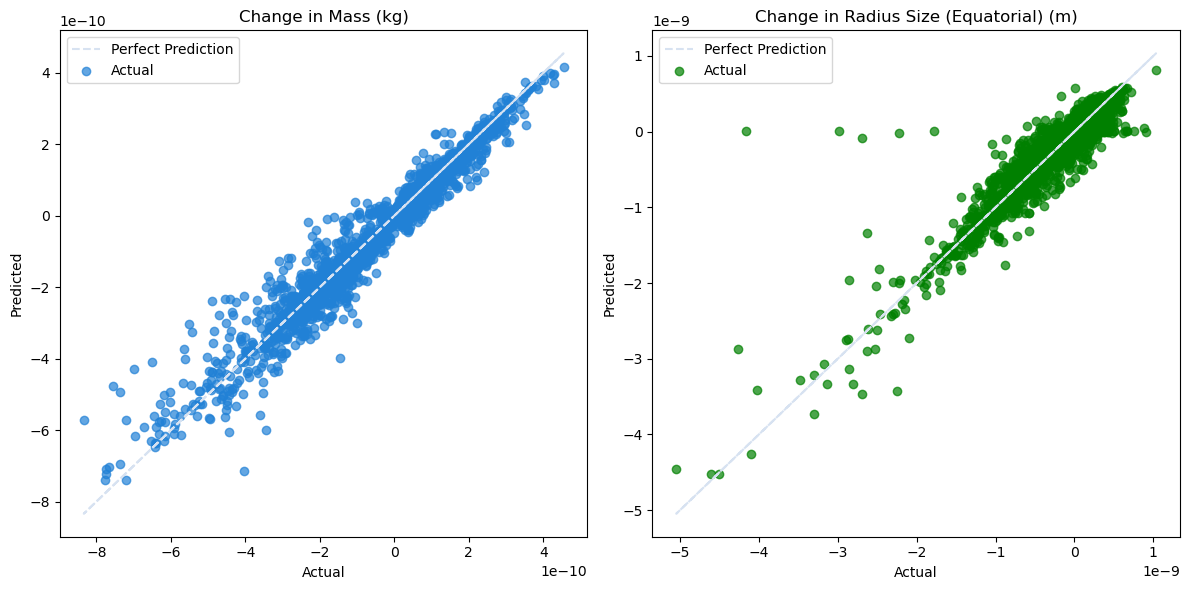

In [87]:
# Plot for Output 1
plt.figure(figsize=(12, 6))  # Adjust width and height as needed

plt.subplot(1, 2, 1)
plt.plot(actual_output11, actual_output11, color='#D7E2F1', linestyle='--', label='Perfect Prediction')
plt.scatter(actual_output11, predicted_output11, color='#2181D6', marker='o', label='Actual', alpha=0.7)
plt.title('Change in Mass (kg)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Plot for Output 2
plt.subplot(1, 2, 2)
plt.plot(actual_output22, actual_output22, color='#D7E2F1', linestyle='--', label='Perfect Prediction')
plt.scatter(actual_output22, predicted_output22, color='green', marker='o', label='Actual', alpha=0.7)
plt.title('Change in Radius Size (Equatorial) (m)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.tight_layout()
plt.show()